## Caso de estudio

- Dataset original: https://www.kaggle.com/datasets/ravichan76/leadscore?resource=download

- LeadScoringAI by Human Trends: https://leadscoring.ai

## Presentación del problema

X Education es una empresa de educación que vende cursos en línea para profesionales de la industria. Su sitio web recibe diariamente a muchas personas interesadas en estos cursos, quienes pueden navegar por la oferta, completar formularios o ver videos.

La empresa promociona sus cursos a través de sitios web y motores de búsqueda como Google. Cuando un visitante llena un formulario con su correo electrónico o número de teléfono, se clasifica como un lead. Además, también obtienen leads a través de referencias previas. Luego, el equipo de ventas se encarga de contactar a estos leads mediante llamadas y correos electrónicos. Sin embargo, solo un 30% de los leads se convierten en clientes.

Dado que se generan muchos leads, pero solo una parte se convierte en clientes de pago, es clave nutrir a los leads más prometedores mediante educación y comunicación constante para aumentar la tasa de conversión.

## Problema a resolver:
X Education necesita un modelo que asigne un lead score a cada prospecto, permitiendo identificar los más propensos a convertirse en clientes. El objetivo es mejorar la conversión, buscando alcanzar un 80% según las expectativas del CEO.

## Objetivos del estudio
- Aprendizaje supervisado:
  - Procesar datos (práctica anterior)
  - Separamos en datos de entrenamiento y test
  - Probamos varios modelos
  - Elegimos el mejor (en base a métricas y criterios adecuados)
  - <b>Conclusión: asegurarnos que el mejor modelo generalice bien.</b>

- Aprendizaje no supervisado
  - Preparación de los datos (práctica anterior)
  - Reducción de dimensionalidad (PCA)
  - Clustering: queremos encontrar segmentos de clientes (Customer Value Management).
  - <b>Conclusión: asegurar que entendemos los tipos de clientes que existen.</b>

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

# Data display customization
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


# importing sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

In [2]:
#### Funciones auxiliares ######
def porcentaje_nulos(dataframe):
    # Calcula el porcentaje de valores nulos en cada columna
    porcentaje_nas = (dataframe.isnull().mean() * 100).round(2)

    # Convierte la información a un diccionario
    dict_nulos = porcentaje_nas.to_dict()

    return dict_nulos

def eliminar_columnas_con_nulos(df, umbral=0.15):

    # Calcula el porcentaje de valores nulos por columna
    porcentaje_nulos = df.isnull().mean()

    # Filtra las columnas que tienen menos del umbral de valores nulos
    columnas_a_mantener = porcentaje_nulos[porcentaje_nulos <= (1 - umbral)].index

    # Crea un nuevo DataFrame con las columnas seleccionadas
    df_resultante = df[columnas_a_mantener].copy()

    return df_resultante

# EDA

## Paso 1: Leemos los datos

In [3]:
leads_df = pd.read_csv('/content/Leads.csv')

## Paso 2: Estudiamos información básica del dataset

In [4]:
# nos fijamos las dimensiones del dataset
leads_df.shape

(9240, 37)

In [5]:
# inspeccionamos datos
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

## Paso 3: Estudiamos estadística descriptiva del dataset

In [6]:
# variables numéricas
leads_df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [7]:
# variables categóricas
leads_df.describe(include='object')

,Prospect ID,Lead Origin,Lead Source,Do Not Email,Do Not Call,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
count,9240,9240,9204,9240,9240,9137,6779,7802,7033,6550,6531,9240,9240,9240,9240,9240,9240,9240,9240,5887,4473,9240,9240,6531,7820,5022,5022,9240,9240,9240
unique,9240,5,21,2,2,17,38,19,10,6,3,2,1,2,2,2,2,2,1,26,5,1,1,6,7,3,3,1,2,16
top,571b5c8e-a5b2-4d57-8574-f2ffb06fdeff,Landing Page Submission,Google,No,No,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,02.Medium,No,No,Modified
freq,1,4886,2868,8506,9238,3437,6492,1942,5043,5600,6528,9226,9240,9238,9239,9239,9236,9233,9240,2072,1560,9240,9240,4146,3222,3839,2788,9240,6352,3407


## Paso 4: Matriz de correlación entre variables

In [8]:
leads_df.corr(numeric_only=True)

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
Lead Number,1.000000,0.025157,0.022223,0.020329,0.058808,-0.067982,-0.129124
Converted,0.025157,1.000000,0.030395,0.362483,-0.003328,0.167962,0.218571
TotalVisits,0.022223,0.030395,1.000000,0.221240,0.512125,-0.058514,0.130887
Total Time Spent on Website,0.020329,0.362483,0.221240,1.000000,0.320361,-0.065287,0.175589
Page Views Per Visit,0.058808,-0.003328,0.512125,0.320361,1.000000,-0.162892,0.161254
Asymmetrique Activity Score,-0.067982,0.167962,-0.058514,-0.065287,-0.162892,1.000000,-0.123250
Asymmetrique Profile Score,-0.129124,0.218571,0.130887,0.175589,0.161254,-0.123250,1.000000


In [9]:
leads_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
Lead Number,1.000000,0.025157,0.022223,0.020329,0.058808,-0.067982,-0.129124
Converted,0.025157,1.000000,0.030395,0.362483,-0.003328,0.167962,0.218571
TotalVisits,0.022223,0.030395,1.000000,0.221240,0.512125,-0.058514,0.130887
Total Time Spent on Website,0.020329,0.362483,0.221240,1.000000,0.320361,-0.065287,0.175589
Page Views Per Visit,0.058808,-0.003328,0.512125,0.320361,1.000000,-0.162892,0.161254
Asymmetrique Activity Score,-0.067982,0.167962,-0.058514,-0.065287,-0.162892,1.000000,-0.123250
Asymmetrique Profile Score,-0.129124,0.218571,0.130887,0.175589,0.161254,-0.123250,1.000000


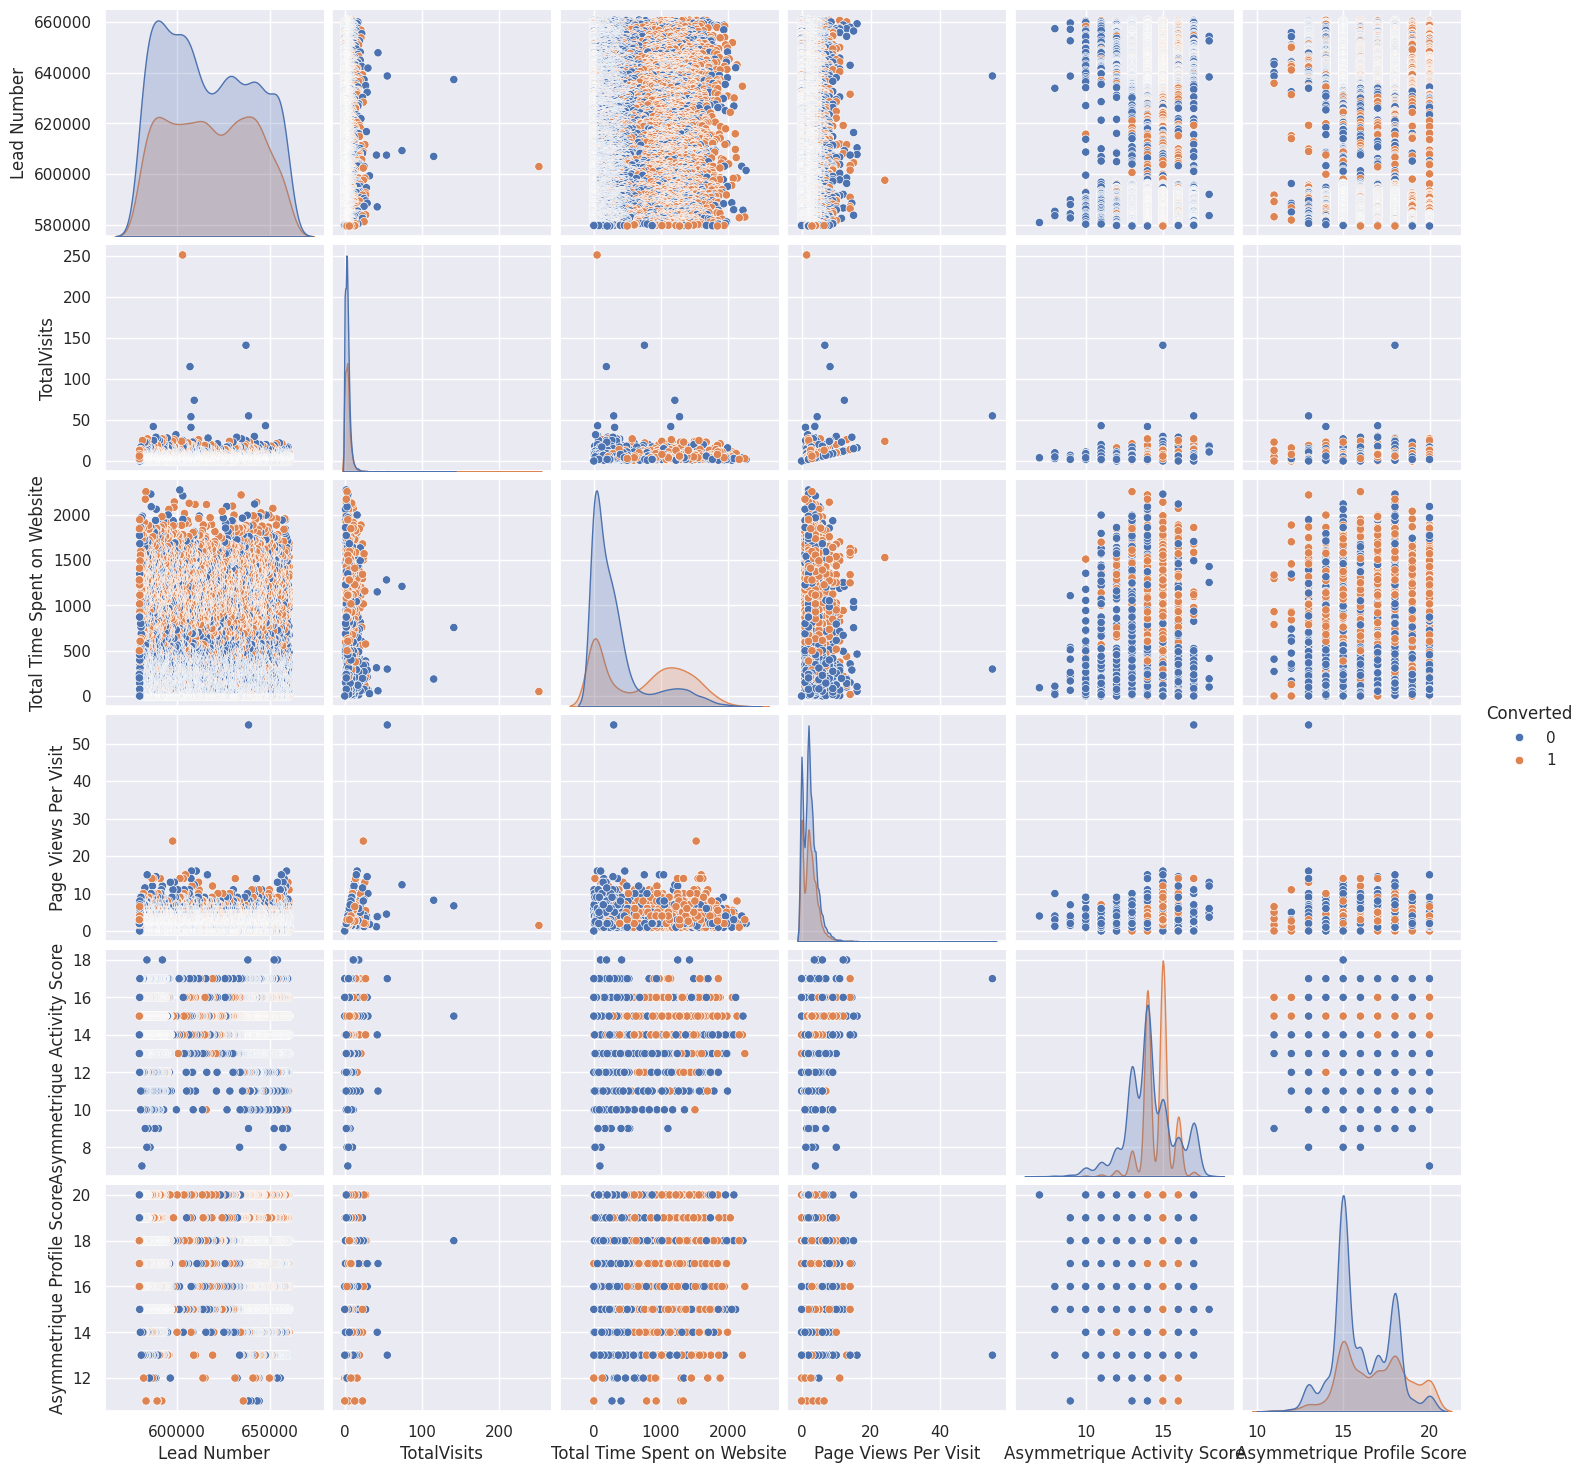

In [10]:
sns.pairplot(data=leads_df, hue="Converted")

## Paso 5: Inspección de características

In [11]:
# % de valores perdidos por variable
porcentaje_nulos(leads_df)

{'Prospect ID': 0.0,
 'Lead Number': 0.0,
 'Lead Origin': 0.0,
 'Lead Source': 0.39,
 'Do Not Email': 0.0,
 'Do Not Call': 0.0,
 'Converted': 0.0,
 'TotalVisits': 1.48,
 'Total Time Spent on Website': 0.0,
 'Page Views Per Visit': 1.48,
 'Last Activity': 1.11,
 'Country': 26.63,
 'Specialization': 15.56,
 'How did you hear about X Education': 23.89,
 'What is your current occupation': 29.11,
 'What matters most to you in choosing a course': 29.32,
 'Search': 0.0,
 'Magazine': 0.0,
 'Newspaper Article': 0.0,
 'X Education Forums': 0.0,
 'Newspaper': 0.0,
 'Digital Advertisement': 0.0,
 'Through Recommendations': 0.0,
 'Receive More Updates About Our Courses': 0.0,
 'Tags': 36.29,
 'Lead Quality': 51.59,
 'Update me on Supply Chain Content': 0.0,
 'Get updates on DM Content': 0.0,
 'Lead Profile': 29.32,
 'City': 15.37,
 'Asymmetrique Activity Index': 45.65,
 'Asymmetrique Profile Index': 45.65,
 'Asymmetrique Activity Score': 45.65,
 'Asymmetrique Profile Score': 45.65,
 'I agree to pay

In [12]:
# Nos fijamos si hay duplicados
leads_df.loc[leads_df.duplicated()]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity


In [13]:
leads_df.Converted.value_counts(normalize=True) * 100 # 0 no convertido, 1 convertido

,proportion
Converted,
0,61.461039
1,38.538961


## Conclusiones relevantes del EDA básico

- La forma del conjunto de datos de leads es de 9.240 filas y 37 columnas.
- Hay 7 columnas numéricas y 30 columnas categóricas.
- Hay valores faltantes/nulos en varias columnas.
- No hay valores duplicados en el conjunto de datos.
- La tasa de conversión de los leads es del 38.54%.
- Variable objetivo: Converted, problema binario de clasificación.
- Clases un poco desbalanceadas (No mucho)
- En muchos casos existe una categoría "Select" que representa un valor faltante. Esto viene dado por el CRM (Customer Relationship Management) utilizado ya que no seleccionarion la opción. Tendremos que arreglarlo en el preprocesamiento.

# Preprocesamiento de datos y limpieza

## Paso 1: Manejo de valores faltantes

In [14]:
# Reemplazamos los 'Select' por NaN para tratarlos como 'missing values'
leads_df = leads_df.replace('Select', np.nan)

In [15]:
# volvemos a ver el % de valores perdidos por columna
porcentaje_nulos(leads_df)

{'Prospect ID': 0.0,
 'Lead Number': 0.0,
 'Lead Origin': 0.0,
 'Lead Source': 0.39,
 'Do Not Email': 0.0,
 'Do Not Call': 0.0,
 'Converted': 0.0,
 'TotalVisits': 1.48,
 'Total Time Spent on Website': 0.0,
 'Page Views Per Visit': 1.48,
 'Last Activity': 1.11,
 'Country': 26.63,
 'Specialization': 36.58,
 'How did you hear about X Education': 78.46,
 'What is your current occupation': 29.11,
 'What matters most to you in choosing a course': 29.32,
 'Search': 0.0,
 'Magazine': 0.0,
 'Newspaper Article': 0.0,
 'X Education Forums': 0.0,
 'Newspaper': 0.0,
 'Digital Advertisement': 0.0,
 'Through Recommendations': 0.0,
 'Receive More Updates About Our Courses': 0.0,
 'Tags': 36.29,
 'Lead Quality': 51.59,
 'Update me on Supply Chain Content': 0.0,
 'Get updates on DM Content': 0.0,
 'Lead Profile': 74.19,
 'City': 39.71,
 'Asymmetrique Activity Index': 45.65,
 'Asymmetrique Profile Index': 45.65,
 'Asymmetrique Activity Score': 45.65,
 'Asymmetrique Profile Score': 45.65,
 'I agree to pay

Existen variables con un alto grado de missing values:
  - 'How did you hear about X Education' ~ 78%
  - 'Lead Profile' ~ 74%

Estas es mejor eliminarlas ya que si utilizamos algún método de imputación podemos estar incurriendo en sesgos a la hora de decidir.

Luego vienen otras con menos, pero aun así bastantes:
  - 'Country' ~ 27%
  - 'What is your current occupation' ~ 29%
  - 'What matters most to you in choosing a course' ~ 29%
  - 'Lead Quality' ~ 52%
  - 'City' ~ 40%
  - 'Asymmetrique Activity Index' ~ 46%
  - 'Asymmetrique Profile Index' ~ 46%
  - 'Asymmetrique Activity Score' ~ 46%
  - 'Asymmetrique Profile Score' ~ 46%
  - 'Tags' ~ 36%
  - 'Specialization' ~ 37%

In [16]:
# estudiamos en detalle las variables para entender de qué forma será mejor imputarlas
leads_df['Lead Profile'].value_counts()

,count
Lead Profile,
Potential Lead,1613
Other Leads,487
Student of SomeSchool,241
Lateral Student,24
Dual Specialization Student,20


In [17]:
leads_df['How did you hear about X Education'].value_counts()

,count
How did you hear about X Education,
Online Search,808
Word Of Mouth,348
Student of SomeSchool,310
Other,186
Multiple Sources,152
Advertisements,70
Social Media,67
Email,26
SMS,23


Las podemos eliminar, son variables que dan información similar a 'Lead Source' y 'Lead Origin'

In [18]:
# las eliminamos
leads_df = leads_df.drop(['Lead Profile',
                         'How did you hear about X Education'], axis=1)

Ahora estudiamos las que tienen 46% de missing values, parecen bastante similares

<Axes: ylabel='Density'>

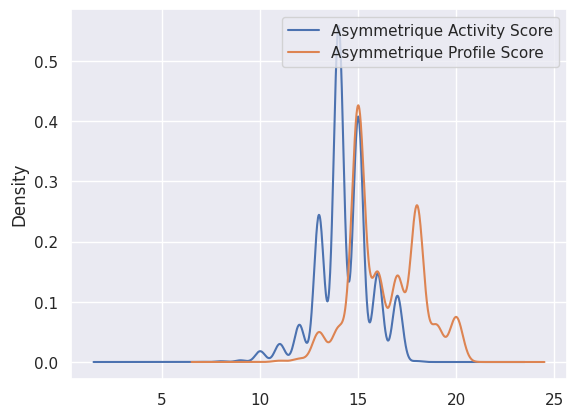

In [19]:
leads_df[['Asymmetrique Activity Score', 'Asymmetrique Profile Score']].plot(kind='kde')

In [20]:
leads_df['Asymmetrique Activity Index'].value_counts()

,count
Asymmetrique Activity Index,
02.Medium,3839
01.High,821
03.Low,362


In [21]:
leads_df['Asymmetrique Profile Index'].value_counts()

,count
Asymmetrique Profile Index,
02.Medium,2788
01.High,2203
03.Low,31


In [22]:
# vemos data quality (también tiene un % alto)
leads_df['Lead Quality'].value_counts()

,count
Lead Quality,
Might be,1560
Not Sure,1092
High in Relevance,637
Worst,601
Low in Relevance,583


Pueden llegar a ser variables útiles, pero siguen teniendo un gran % de missing values.

Hay varios procesos que se pueden hacer:
  - Imputar valores numéricos a través de métricas estadísticas como mediana, moda, etc. Pero al ser tanto el % puede incurrir en sesgos en un futuro modelo.
  - Imputar categóricas inventando una variable "Otro" o "Desconocido", pero tampoco es muy recomendable con % de valores más allá del 30%.

Para este caso práctico las eliminaremos.

El caso de 'Lead Quality' puede ser una variable muy interesante a tener en cuenta. Pero si la miramos con ojos críticos ya es casi un lead scoring en sí mismo. Si queremos un modelo objetivo, no nos conviene ser juiciosos de entrada. Queremos un modelo lo más objetivo posible, por lo que también la quitamos.

<b>Dejamos como ejercicio probar hacer un modelo con estas variables y ver cuánto cambia.</b>

In [23]:
# las eliminamos
leads_df = leads_df.drop(columns=['Lead Quality',
                       'Asymmetrique Activity Index',
                       'Asymmetrique Profile Index',
                       'Asymmetrique Activity Score',
                       'Asymmetrique Profile Score'], axis = 1)

Las variables que nos quedan, las podemos imputar con técnicas simples pero eficientes, para poder trabajar con datos que no tengan missing values. Vamos a estudiar una a una.

In [24]:
 leads_df['Country'].value_counts(normalize=True).head() * 100 # 95% de los datos son de India. Prácticamente es una variable única.

,proportion
Country,
India,95.766337
United States,1.017849
United Arab Emirates,0.781826
Singapore,0.354035
Saudi Arabia,0.309780


In [25]:
 leads_df['City'].value_counts(normalize=True) * 100 # ~ 40% de missing values y principalmente son ciudades de India.

,proportion
City,
Mumbai,57.835218
Thane & Outskirts,13.498474
Other Cities,12.313768
Other Cities of Maharashtra,8.203195
Other Metro Cities,6.821038
Tier II Cities,1.328307


In [26]:
 leads_df['What is your current occupation'].value_counts(normalize=True) # ya existe una clase 'Other' por lo que podemos imputar con esa

,proportion
What is your current occupation,
Unemployed,0.854962
Working Professional,0.107786
Student,0.032061
Other,0.002443
Housewife,0.001527
Businessman,0.001221


In [27]:
leads_df['What matters most to you in choosing a course'].value_counts(normalize=True) # 99% de los datos son Better Career Prospects. Prácticamente es una variable única.

,proportion
What matters most to you in choosing a course,
Better Career Prospects,0.999541
Flexibility & Convenience,0.000306
Other,0.000153


De estas variables, la que más información útil arroja es 'What is your current occupation', la cual imputaremos sus missing values con la categoría 'Other'.

Las otras tres tienen en muchos valores en una categoría específica ('What matters most to you in choosing a course' y 'Country'), luego no aportan información útil. En cuanto a 'City', la gran mayoría de ellas arroja información sobre la India por lo que volvemos al mismo caso que comentamos anteriormente.

In [28]:
leads_df['What is your current occupation'] = leads_df['What is your current occupation'].fillna('Other')

In [29]:
# eliminamos las otras
leads_df = leads_df.drop(['City',
                          'Country',
                          'What matters most to you in choosing a course'], axis=1)

Dentro del estudio de missing values con mayor % nos quedan las variables 'Tags' y 'Specialization'. Vamos a estudiarlas en detalle.

In [30]:
leads_df['Tags'].value_counts(normalize=True) # esta bastante bien distribuido, puede aportar información útil

,proportion
Tags,
Will revert after reading the email,0.351962
Ringing,0.204349
Interested in other courses,0.087141
Already a student,0.078988
Closed by Horizzon,0.060812
switched off,0.040768
Busy,0.031595
Lost to EINS,0.029727
Not doing further education,0.024631


In [31]:
leads_df['Specialization'].value_counts(normalize=True) # esta es la carrera que va a estudiar, puede agregar información útil o incurrir en sesgos (debate)

,proportion
Specialization,
Finance Management,0.166553
Human Resource Management,0.144710
Marketing Management,0.143003
Operations Management,0.085836
Business Administration,0.068771
IT Projects Management,0.062457
Supply Chain Management,0.059556
"Banking, Investment And Insurance",0.057679
Media and Advertising,0.034642


'Tags' la imputaremos con una nueva categoría denominada 'Unknown'.

El caso de 'Specialization' se presta a debate, hay quiénes la agregarían por ser información útil y objetiva y hay quiénes no la agregarían por poder incurrir en sesgos de priorizar carreras por la frecuencia estadística de los usuarios.

En este caso, imputaremos 'Tags' y eliminaremos 'Specialization'.

<b>Como ejercicio se deja probar el modelo con 'Specialization' incluida</b>

In [32]:
leads_df['Tags'] = leads_df['Tags'].fillna('Unknown')

In [33]:
leads_df = leads_df.drop('Specialization', axis=1)

Nos quedan 4 variables con ~1% de missing values, utilizaremos unos métodos similares para imputarlas.

In [34]:
leads_df['Lead Source'].value_counts(normalize=True) # al ser fuentes tan específicas, armaremos una categoróa 'Other'

,proportion
Lead Source,
Google,0.311604
Direct Traffic,0.276293
Olark Chat,0.190678
Organic Search,0.125380
Reference,0.058018
Welingak Website,0.015428
Referral Sites,0.013581
Facebook,0.005976
bing,0.000652


In [35]:
leads_df['Last Activity'].value_counts(normalize=True) # de igual forma, pondremos una clase como 'Unknown' para los missing values

,proportion
Last Activity,
Email Opened,0.376163
SMS Sent,0.300427
Olark Chat Conversation,0.106490
Page Visited on Website,0.070045
Converted to Lead,0.046843
Email Bounced,0.035679
Email Link Clicked,0.029222
Form Submitted on Website,0.012696
Unreachable,0.010178


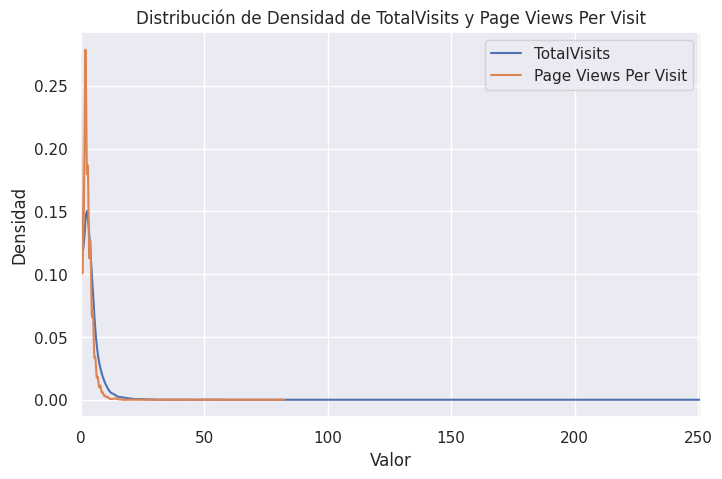

In [36]:
# las otras dos variables son 'TotalVisits' y 'Page Views Per Visit', ambas numéricas. Luego imputaremos atendiendo a su distribución.
ax = leads_df[['TotalVisits', 'Page Views Per Visit']].plot(kind='kde', figsize=(8, 5))

x_min = leads_df[['TotalVisits', 'Page Views Per Visit']].min().min()
x_max = leads_df[['TotalVisits', 'Page Views Per Visit']].max().max()

# Ajustar el rango del eje X
ax.set_xlim(x_min, x_max)

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Distribución de Densidad de TotalVisits y Page Views Per Visit')

# Mostrar el gráfico
plt.show()

In [37]:
leads_df[['TotalVisits', 'Page Views Per Visit']].describe()

,TotalVisits,Page Views Per Visit
count,9103.000000,9103.000000
mean,3.445238,2.362820
std,4.854853,2.161418
min,0.000000,0.000000
25%,1.000000,1.000000
50%,3.000000,2.000000
75%,5.000000,3.000000
max,251.000000,55.000000


Son variable con picos muy pronunciados en sus medianas y sus medias y medianas se aproximan bastante. Luego, imputaremos usando la media. Aunque bien se podría haber usado la mediana.

In [38]:
# imputamos categóricas
leads_df['Last Activity'] = leads_df['Last Activity'].fillna('Unknown')
leads_df['Lead Source'] = leads_df['Lead Source'].fillna('Other')

In [39]:
# imputamos numéricas
leads_df['TotalVisits'] = leads_df['TotalVisits'].fillna(leads_df['TotalVisits'].mean())
leads_df['Page Views Per Visit'] = leads_df['Page Views Per Visit'].fillna(leads_df['Page Views Per Visit'].mean())

In [40]:
# eliminamos Prospect Id ya que es una variable que distingue al lead, pero para eso tambien tenemos 'Lead Number'
leads_df = leads_df.drop('Prospect ID', axis=1)

In [41]:
# volvemos a ver missing values
porcentaje_nulos(leads_df)

{'Lead Number': 0.0,
 'Lead Origin': 0.0,
 'Lead Source': 0.0,
 'Do Not Email': 0.0,
 'Do Not Call': 0.0,
 'Converted': 0.0,
 'TotalVisits': 0.0,
 'Total Time Spent on Website': 0.0,
 'Page Views Per Visit': 0.0,
 'Last Activity': 0.0,
 'What is your current occupation': 0.0,
 'Search': 0.0,
 'Magazine': 0.0,
 'Newspaper Article': 0.0,
 'X Education Forums': 0.0,
 'Newspaper': 0.0,
 'Digital Advertisement': 0.0,
 'Through Recommendations': 0.0,
 'Receive More Updates About Our Courses': 0.0,
 'Tags': 0.0,
 'Update me on Supply Chain Content': 0.0,
 'Get updates on DM Content': 0.0,
 'I agree to pay the amount through cheque': 0.0,
 'A free copy of Mastering The Interview': 0.0,
 'Last Notable Activity': 0.0}

## Paso 2: Estudio de variables monocategóricas

In [42]:
# Chequeamos valores únicos por columna
leads_df.nunique()

,0
Lead Number,9240
Lead Origin,5
Lead Source,22
Do Not Email,2
Do Not Call,2
Converted,2
TotalVisits,42
Total Time Spent on Website,1731
Page Views Per Visit,115
Last Activity,18


Quitamos las que únicamente tenga un valor ya que no aportan información útil.

In [43]:
# las eliminamos
leads_df = leads_df.drop(['Magazine',
                         'Receive More Updates About Our Courses',
                         'I agree to pay the amount through cheque',
                         'Get updates on DM Content',
                         'Update me on Supply Chain Content'], axis=1)

## Paso 3: estudio de variables que nos quedaron (estudio de outliers, ingeniería de características)

In [69]:
leads_df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity',
       'What is your current occupation', 'Tags',
       'A free copy of Mastering The Interview'],
      dtype='object')

Habiendo limpiado los valores faltantes y quitado variables de poco interés, ahora procederemos a estudiar en detalle las variables que nos quedaron.

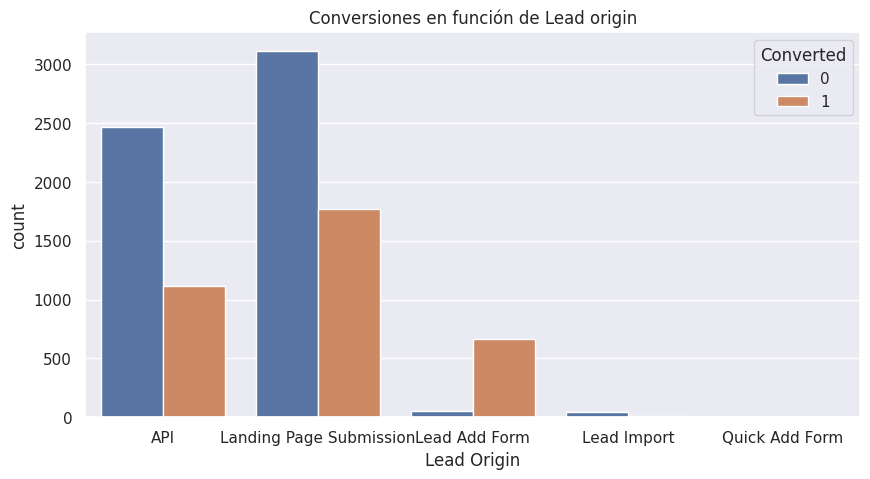

In [45]:
plt.figure(figsize=(10,5))
sns.countplot(x = "Lead Origin", hue = "Converted", data = leads_df)
plt.title("Conversiones en función de Lead origin")
plt.show()

- El **Formulario de Adición de Leads** tiene la tasa de conversión más alta.  
- **API y Envío desde Landing Page** tienen tasas de conversión no muy altas, pero generan la mayor cantidad de leads.  
- **La Importación de Leads** tiene la menor cantidad de conversiones y generación de leads.
- Para mejorar la tasa de conversión general de leads, se debe **enfocar en aumentar la conversión de la API y del Envío desde Landing Page**. Además, **generar más leads desde el Formulario de Adición de Leads**, ya que tiene una tasa de conversión muy alta.


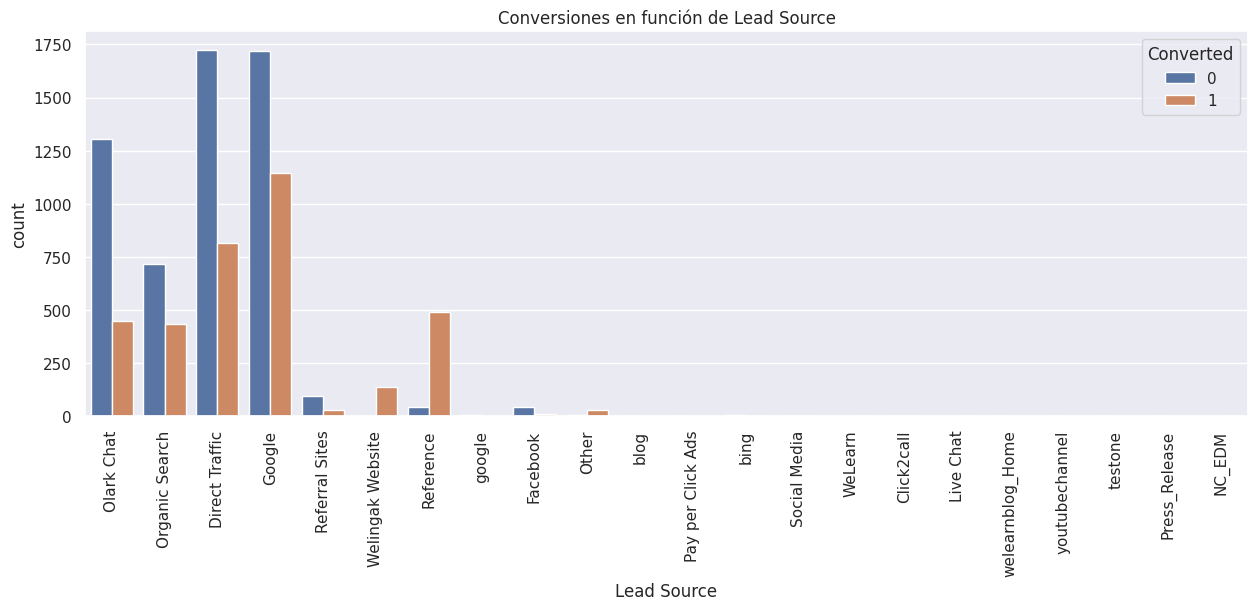

In [46]:
plt.figure(figsize=(15,5))
sns.countplot(x = "Lead Source", hue = "Converted", data = leads_df)
plt.title("Conversiones en función de Lead Source")
plt.xticks(rotation=90)
plt.show()

- Muchas fuentes tienen pocos leads, por lo que sería prudente juntarlos en una única categoría común para agregar menos casuísticas al modelo. Será la categoría 'Others'.
- Además hay 2 categories 'Google', una con mayúscula y otra con minúscula, por lo que las juntaremos.



In [47]:
leads_df['Lead Source'] = leads_df['Lead Source'].replace(['google'], 'Google')
leads_df['Lead Source'] = leads_df['Lead Source'].replace(['Click2call', 'Live Chat', 'NC_EDM', 'Pay per Click Ads', 'Press_Release',
  'Social Media', 'WeLearn', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel', 'Other'], 'Others')

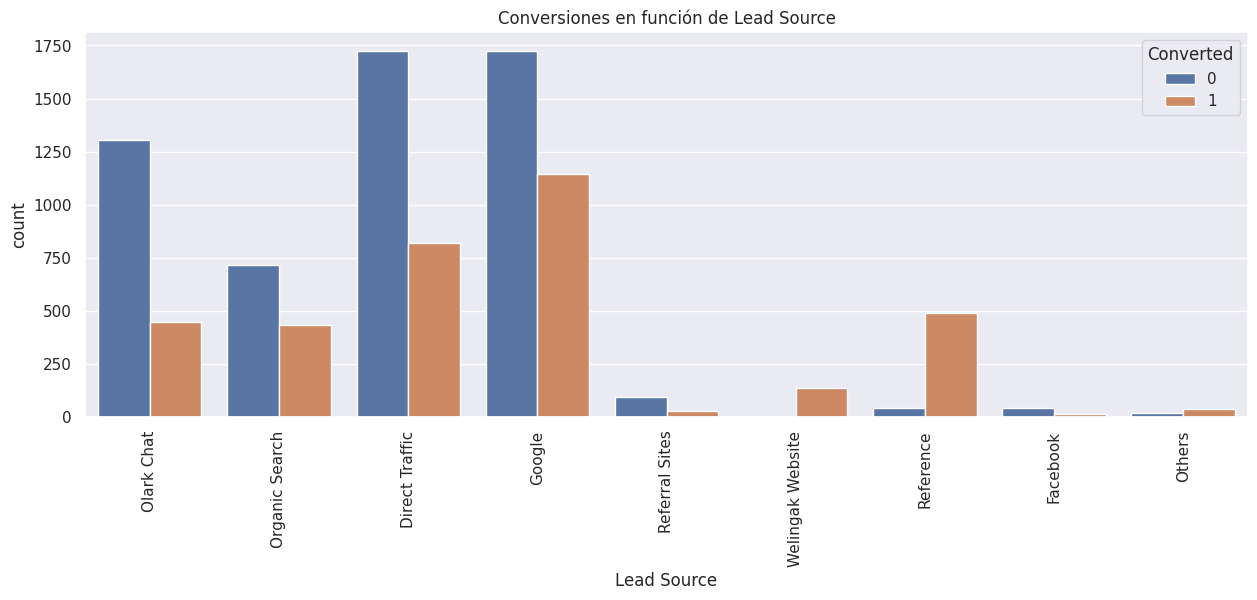

In [48]:
plt.figure(figsize=(15,5))
sns.countplot(x = "Lead Source", hue = "Converted", data = leads_df)
plt.title("Conversiones en función de Lead Source")
plt.xticks(rotation=90)
plt.show()

- Google y direct traffic generates el máximo número de leads.
- Welingak website y References tienen el % de conversión más alto.
- olark chat y organic search generan un buen número de leads, pero no con buena conversión.
- Hay un buen margen de mejora, pero la información que aporta es útil.


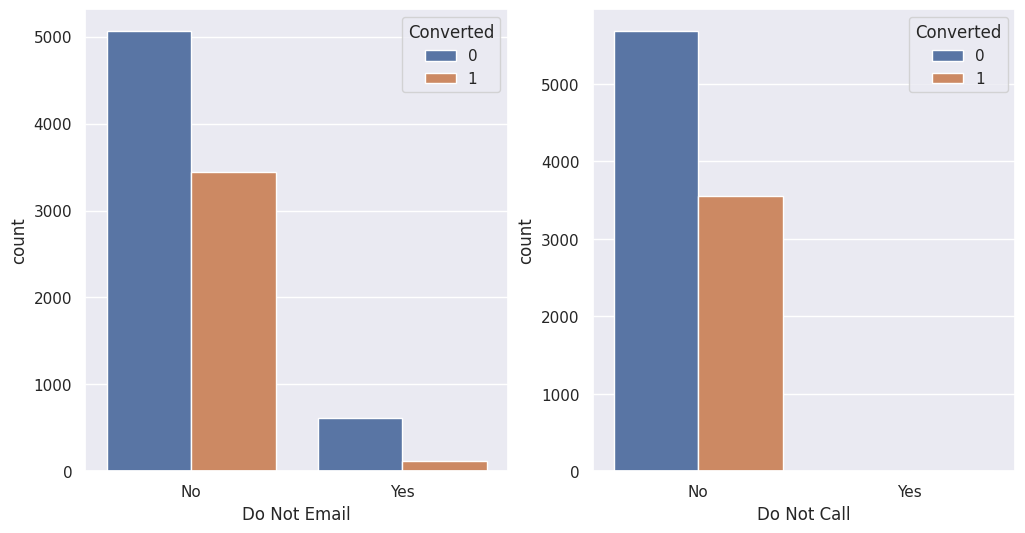

In [49]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
sns.countplot(x = "Do Not Email", hue = "Converted", data = leads_df, ax = axs[0])
sns.countplot(x = "Do Not Call", hue = "Converted", data = leads_df, ax = axs[1])
plt.show()


In [50]:
leads_df['Do Not Call'].value_counts(normalize=True) # prácticamente son todas 'No', información útil de negocio, pero redundante para el modelo.

,proportion
Do Not Call,
No,0.999784
Yes,0.000216


In [51]:
leads_df = leads_df.drop('Do Not Call', axis=1)

- La mayoría de personas que les molesta que les envíen mail no terminan conviertiendo.
- En el caso contrario, vemos como el % de conversión aumenta.

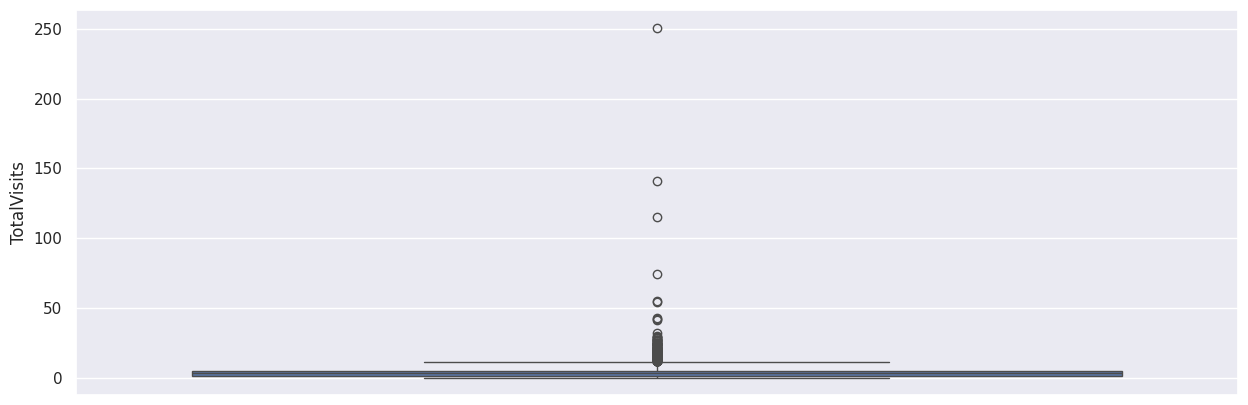

In [52]:
plt.figure(figsize=(15,5))
sns.boxplot(leads_df['TotalVisits'])
plt.show()

- Gran número de outliers. Distribución muy escorada a la izquierda, con una larga cola (outliers), Los vamos a reemplazar por la media, como los missing values. Aquellos que estén por encima del percetil 95.

In [53]:
# Calcular el percentil 95 de la variable TotalVisits
percentil_95 = leads_df['TotalVisits'].quantile(0.95)

# Calcular la media de la variable TotalVisits (para reemplazar outliers)
media_total_visits = leads_df['TotalVisits'].mean()

# Reemplazar valores por encima del percentil 95 con la media
leads_df['TotalVisits'] = np.where(leads_df['TotalVisits'] > percentil_95, media_total_visits, leads_df['TotalVisits'])

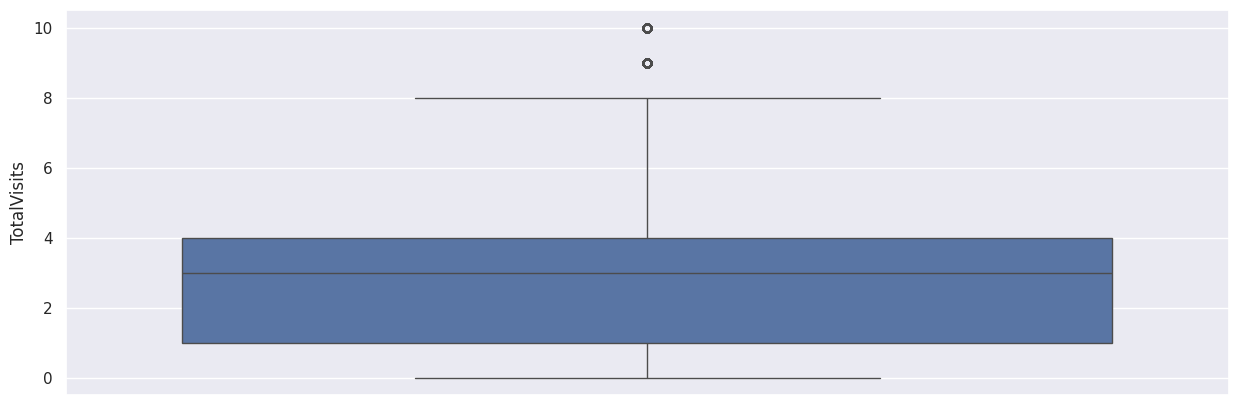

In [54]:
plt.figure(figsize=(15,5))
sns.boxplot(leads_df['TotalVisits'])
plt.show()

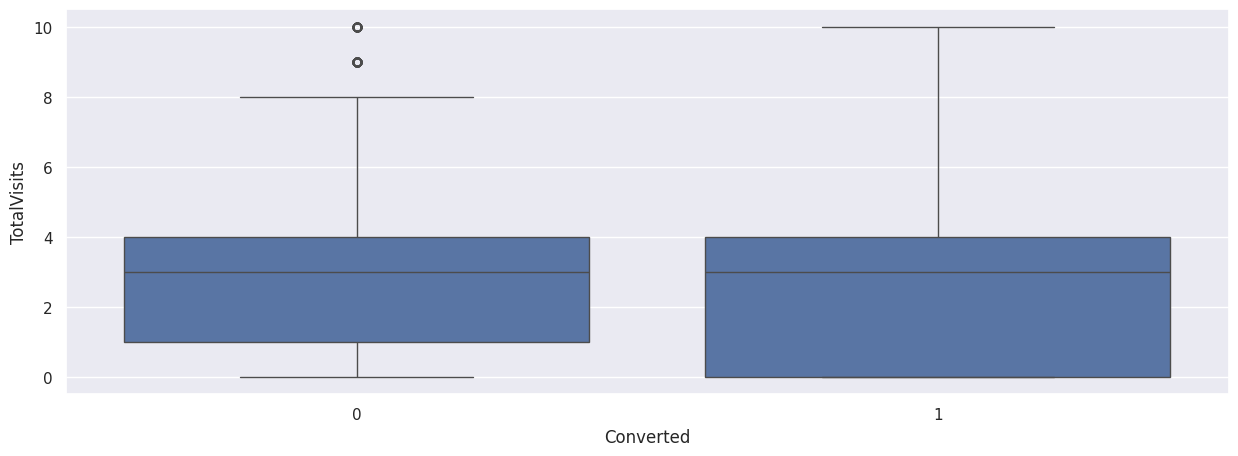

In [55]:
plt.figure(figsize=(15,5))
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = leads_df)
plt.show()

- Medianas muy similares, poca diferencia en la influencia sobre las conversiones.

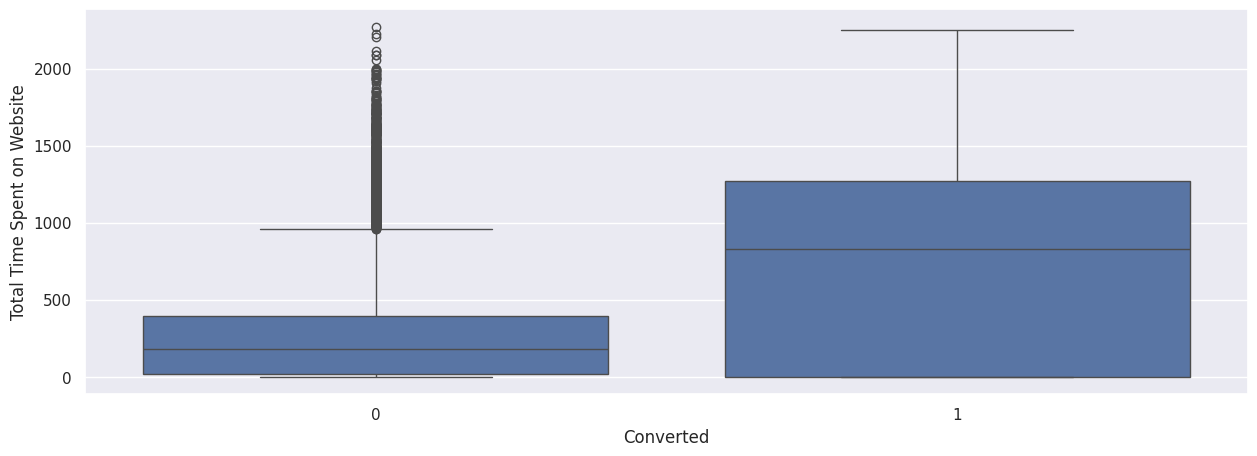

In [56]:
plt.figure(figsize=(15,5))
sns.boxplot(y = 'Total Time Spent on Website', x = 'Converted', data = leads_df)
plt.show()

- Aquellos leads que pasan más tiempo en la web, tienen más chances de convertir, en este caso no los imputamos. Factor clave.


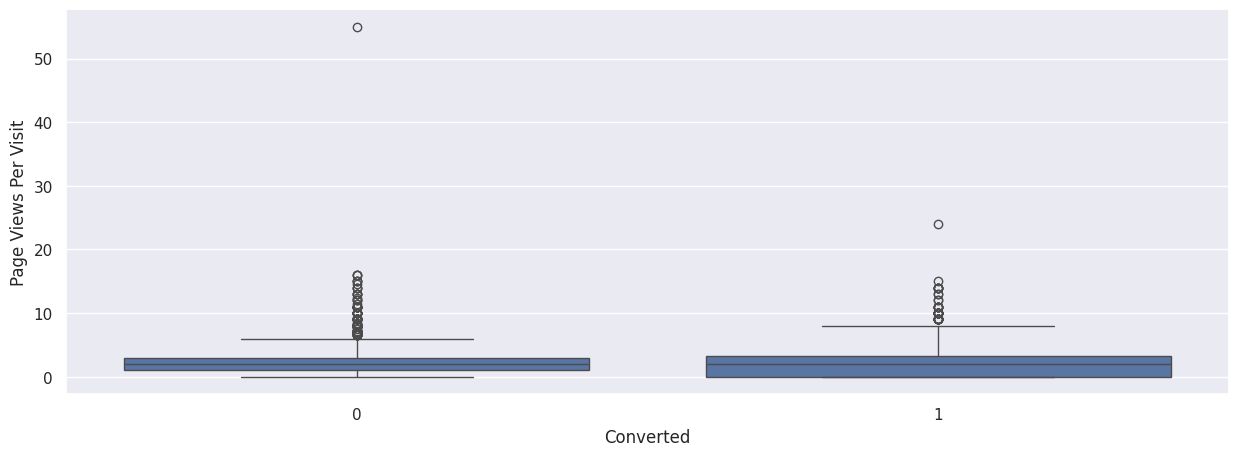

In [57]:
plt.figure(figsize=(15,5))
sns.boxplot(y = 'Page Views Per Visit', x = 'Converted', data = leads_df)
plt.show()

- Al igual que en anterior hay muchos outliers y podemos volver a imputar por la media.


In [58]:
# Calcular el percentil 95 de la variable Page Views Per Visit
percentil_95 = leads_df['Page Views Per Visit'].quantile(0.95)

# Calcular la media de la variable Page Views Per Visit (para reemplazar outliers)
media_total_visits = leads_df['Page Views Per Visit'].mean()

# Reemplazar valores por encima del percentil 95 con la media
leads_df['Page Views Per Visit'] = np.where(leads_df['Page Views Per Visit'] > percentil_95, media_total_visits, leads_df['Page Views Per Visit'])

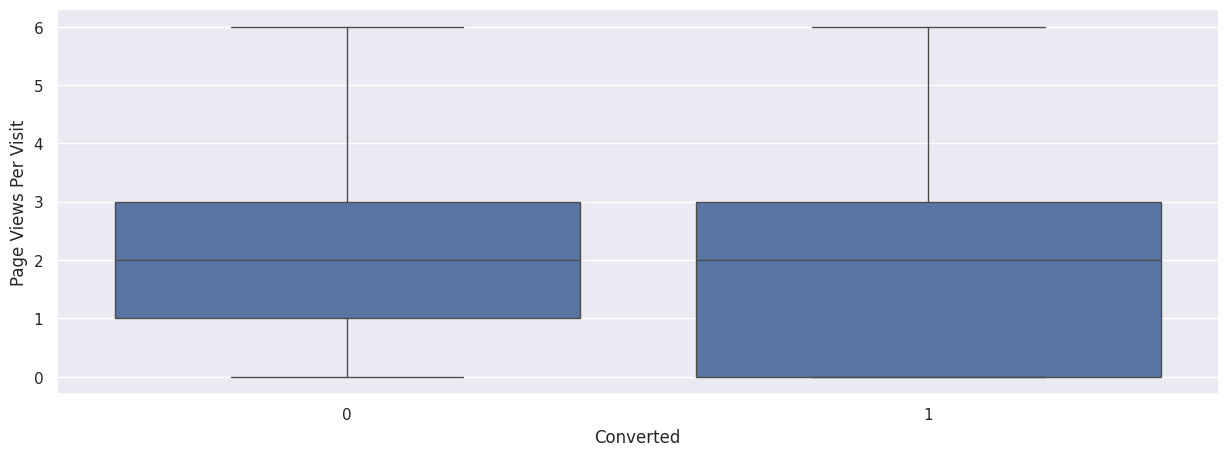

In [59]:
plt.figure(figsize=(15,5))
sns.boxplot(y = 'Page Views Per Visit', x = 'Converted', data = leads_df)
plt.show()

- Leads que visitan 1-3 páginas son personas con una duda razonable si aplicar o no. Estan 50/50.
- Leads que no visitan páginas tienen mayores chances de conversión, eso habla de su convencimiento.    

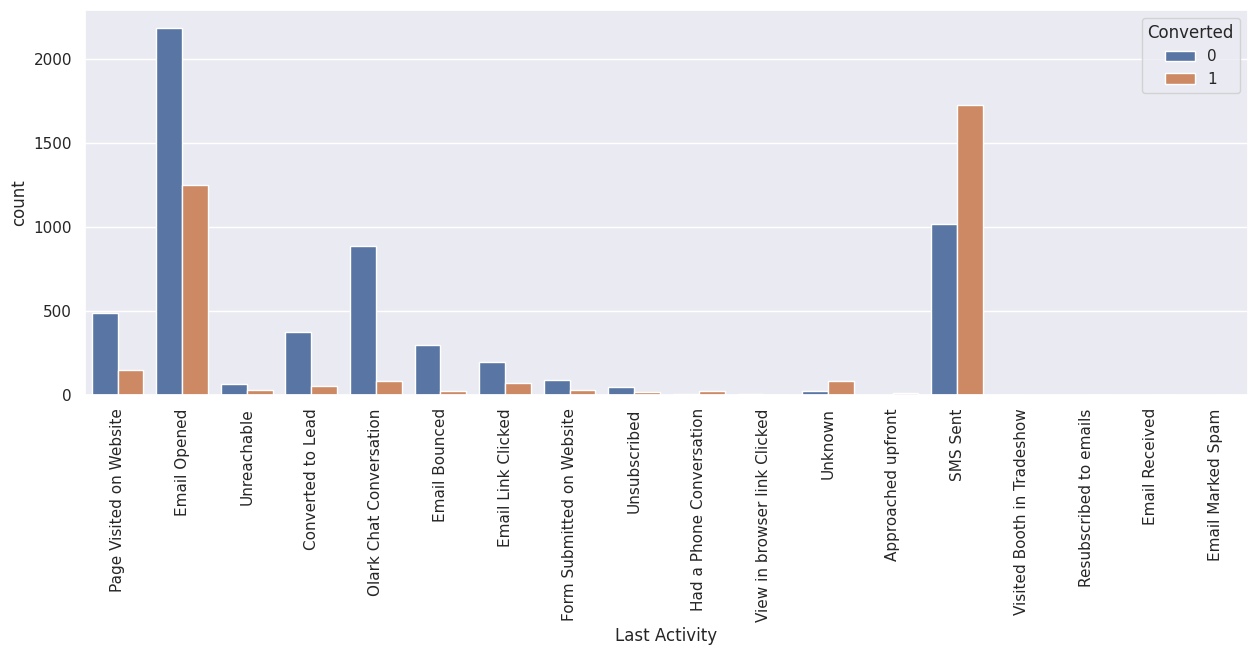

In [60]:
plt.figure(figsize=(15,5))
sns.countplot(x = "Last Activity", hue = "Converted", data = leads_df)
plt.xticks(rotation = 90)
plt.show()

- La mayor cantidad de leads tienen como última actividad 'Email opened' y 'SMS sent'. Incluso tienen altos % de conversión. El del SMS es muy alto.
- 'Unknown' también tiene buenos porcentajes de conversión. Sería interesante tener más información sobre su última actividad.
- 'olark chat conversation' y 'Page Visited on Website' generan muchos leads pero convierten muy poco.



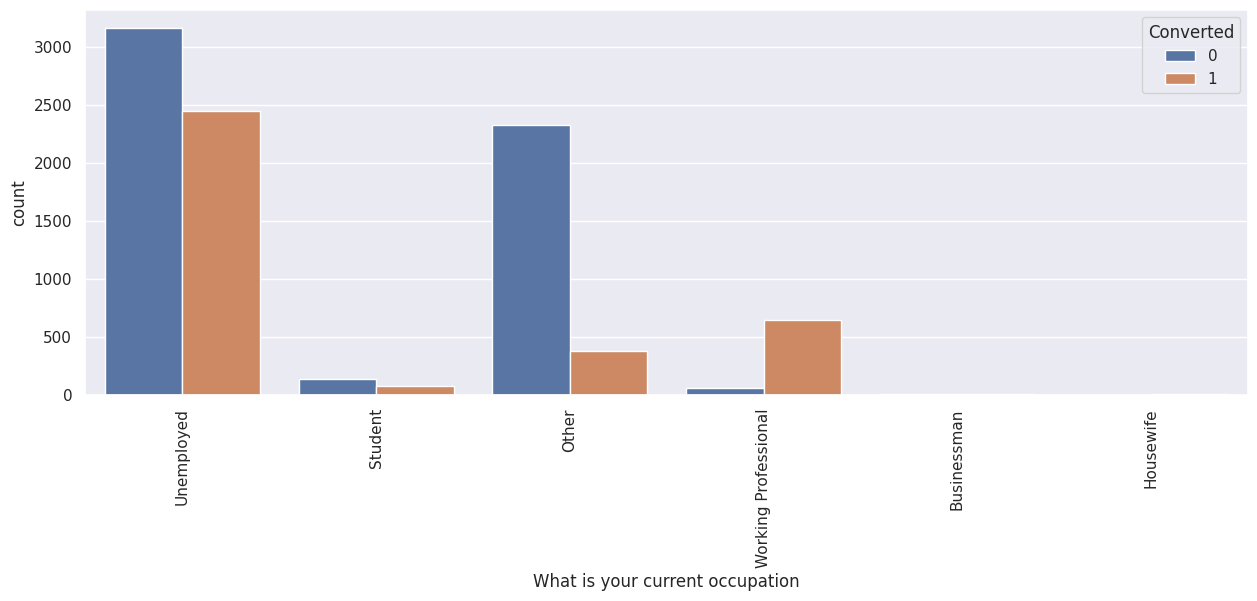

In [61]:
plt.figure(figsize=(15,5))
sns.countplot(x = "What is your current occupation", hue = "Converted", data = leads_df)
plt.xticks(rotation = 90)
plt.show()

- 'Working Professionals' y 'Unemployed' generan muchos leads y convierten con un alto %.
- 'Working Professionals' convierte en un % muy alto.
- Deberían enfocarse en acciones sobre personas con un perfil profesional cualificado.



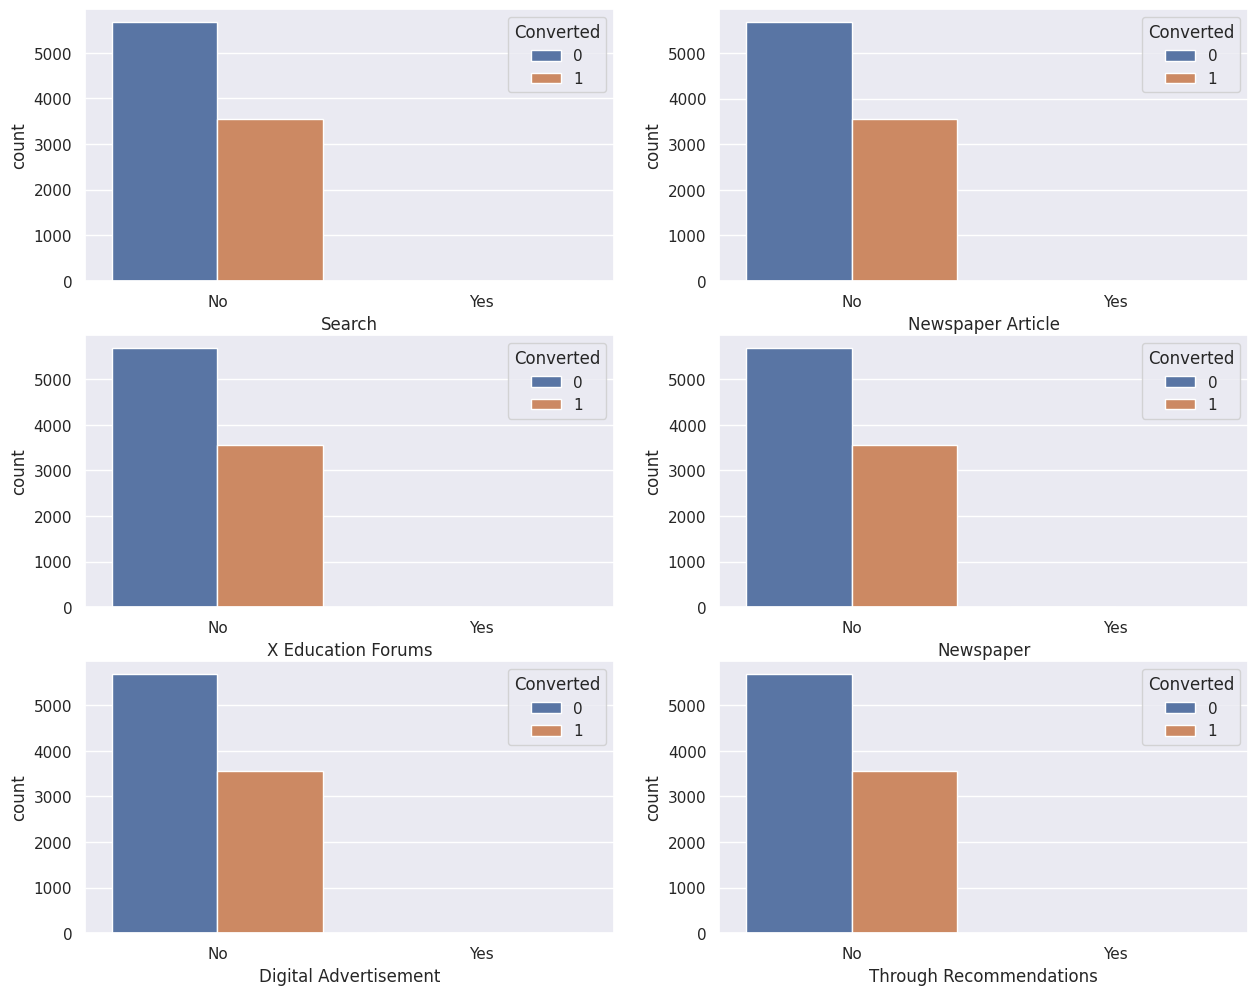

In [62]:
# estudiamos el resto en conjunto
plt.figure(figsize=(15,12))

plt.subplot(3,2,1)
sns.countplot(x = "Search", hue = "Converted", data = leads_df)

plt.subplot(3,2,2)
sns.countplot(x = "Newspaper Article", hue = "Converted", data = leads_df)

plt.subplot(3,2,3)
sns.countplot(x = "X Education Forums", hue = "Converted", data = leads_df)

plt.subplot(3,2,4)
sns.countplot(x = "Newspaper", hue = "Converted", data = leads_df)

plt.subplot(3,2,5)
sns.countplot(x = "Digital Advertisement", hue = "Converted", data = leads_df)

plt.subplot(3,2,6)
sns.countplot(x = "Through Recommendations", hue = "Converted", data = leads_df)

plt.show()

- Insights interesantes a nivel de negocio, pero poco útiles para el modelo. El 99% de las respuestas a estas preguntas no son relevantes para la toma de decisiones del modelo por lo que las podemos eliminar.

In [63]:
leads_df = leads_df.drop(['Search',
                          'Newspaper Article',
                          'X Education Forums',
                          'Newspaper',
                          'Digital Advertisement',
                          'Through Recommendations'], axis=1)

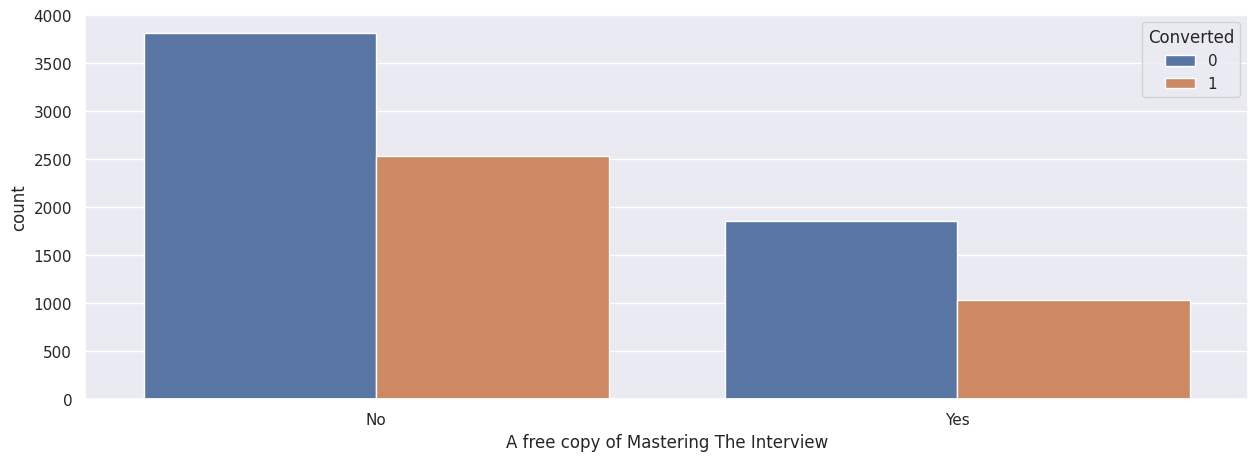

In [64]:
plt.figure(figsize=(15,5))
sns.countplot(x = "A free copy of Mastering The Interview", hue = "Converted", data = leads_df)

plt.show()

- A diferencia de las otras preguntas, esta sí aporta conocimiento al modelo.
- Ratios de conversión similares para aquellos que la quisieron y aquellos que no.
    
   

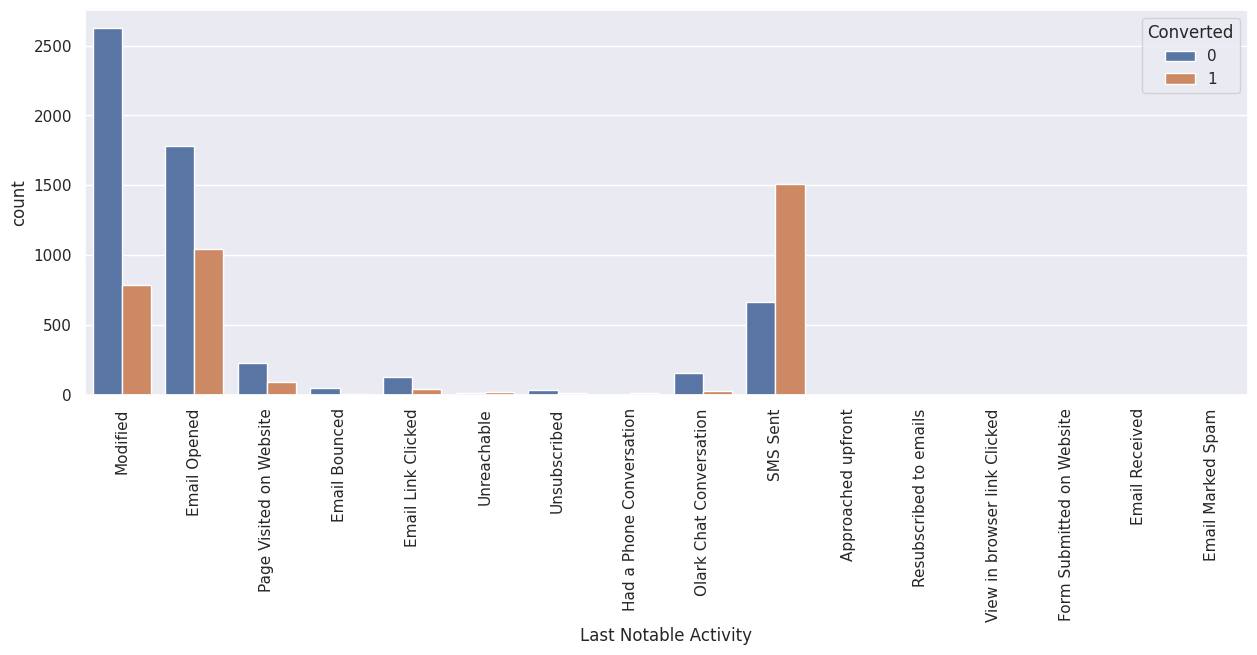

In [65]:
plt.figure(figsize=(15,5))
sns.countplot(x = "Last Notable Activity", hue = "Converted", data = leads_df)
plt.xticks(rotation = 90)
plt.show()

- Similar a 'Last activity', podemos quedaron con una

In [66]:
leads_df = leads_df.drop('Last Notable Activity', axis=1)

In [72]:
leads_df.shape

(9240, 12)

In [71]:
leads_df.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,Tags,A free copy of Mastering The Interview
0,660737,API,Olark Chat,No,0,0.0,0,0.0,Page Visited on Website,Unemployed,Interested in other courses,No
1,660728,API,Organic Search,No,0,5.0,674,2.5,Email Opened,Unemployed,Ringing,No
2,660727,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,Email Opened,Student,Will revert after reading the email,Yes
3,660719,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,Unreachable,Unemployed,Ringing,No
4,660681,Landing Page Submission,Google,No,1,2.0,1428,1.0,Converted to Lead,Unemployed,Will revert after reading the email,No


## Paso 4: Codificación de variables categóricas, estandarización y normalización

In [70]:
leads_df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity',
       'What is your current occupation', 'Tags',
       'A free copy of Mastering The Interview'],
      dtype='object')

Convertimos variables binarias (Yes/No) a 1/0

In [73]:
# Vars binarias
varlist =  ['A free copy of Mastering The Interview','Do Not Email']

# Funcion de mapeo
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# aplicamos el mapeo
leads_df[varlist] = leads_df[varlist].apply(binary_map)

Hacemos un codificación de variables categóricas con un 'one-hot encoding', esto genera una explosión de variables. Pero que serán útiles para entrenar modelos.

In [74]:
dummy = ['Lead Origin', 'Lead Source', 'Last Activity', 'Tags','What is your current occupation']
dummy_data = pd.get_dummies(leads_df[dummy],drop_first=True)
dummy_data.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unknown,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unknown,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False


In [75]:
# combinamos dummy data con el dataset original

leads_df = pd.concat([leads_df, dummy_data], axis=1)
leads_df.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,Tags,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unknown,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unknown,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Unemployed,Interested in other courses,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Unemployed,Ringing,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Student,Will revert after reading the email,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
3,660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,Unemployed,Ringing,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Unemployed,Will revert after reading the email,0,True,False,False,False,False,True,False,False,False,False,Fal

In [76]:
# Quitamos las columnas originales
drop_cols = ['Lead Origin', 'Lead Source', 'Last Activity', 'Tags','What is your current occupation']
leads_df = leads_df.drop(drop_cols, axis=1)
leads_df.head()

,Lead Number,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unknown,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unknown,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,660737,0,0,0.0,0,0.0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,660728,0,0,5.0,674,2.5,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,660727,0,1,2.0,1532,2.0,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
3,660719,0,0,1.0,305,1.0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,660681,0,1,2.0,1428,1.0,0,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False


In [77]:
# vemos la forma actual del dataset
leads_df.shape

(9240, 67)

Futuros pasos:
- Separamos train y test.
- Normalizamos y estandarizamos las variables.
- Armar modelos y hacer pruebas
- Estudiar performance del modelo
- Estudiar cómo generaliza el modelo

In [ ]:
leads_df.to_csv('leads_df_clean.csv', index=False)

# Aprendizaje Supervisado

## Paso 1: Train-Test Split

In [ ]:
# Separamos las X
leads_df = leads_df.dropna()

X = leads_df.drop(['Lead Number', 'Converted'], axis=1)

# Separamos las y
y = leads_df['Converted']

In [ ]:
# Separamos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

In [ ]:
X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unknown,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unknown,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
4715,0,0.000000,0,0.00000,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
7132,0,2.000000,1248,1.00000,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
8954,0,4.000000,387,1.33000,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
5283,1,3.445238,1209,2.36282,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3003,0,3.000000,1354,3.00000,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False


## Paso 2: Estandarización y Normalización

In [ ]:
# Vamos a usar scikit learn StandardScaler
scaler = MinMaxScaler()

# Aplicamos el método a las columnas numéricas, esto hace que los valores estén acotados para evitar influencias de valores mayores sobre otros
X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unknown,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unknown,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
4715,0,0.000000,0.000000,0.000000,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
7132,0,0.200000,0.549296,0.166667,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
8954,0,0.400000,0.170335,0.221667,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
5283,1,0.344524,0.532130,0.393803,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3003,0,0.300000,0.595951,0.500000,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False


## Paso 3: Construimos modelos

Probaremos tres modelos (porblema de clasificación):
- Árboles de decisión
- Ensembles: random forrests
- Support Vector Machines

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Árboles de decisión #1

# Entrenar el modelo de Árbol de Decisión
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred_dt = model.predict(X_test)
y_prob_dt = model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(accuracy_dt)

0.9163059163059163


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forrest #2

# Entrenar el modelo de Random Forrest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)

accuracy_rf

0.933982683982684

In [ ]:
from sklearn.svm import SVC

# Support Vector Machine #3

# Entrenar el modelo de SVM
svm_model = SVC(kernel="linear", probability=True, random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy_svm = accuracy_score(y_test, y_pred_svm)

accuracy_svm

0.9365079365079365

Vamos a hacer predicciones con los tres algoritmos y a graficar los resultados para apreciar qué tan bien lo han hecho. Usaremos las probabilidades de que se conviertan en clientes pagados, es decir la probabilidad de ser la clase "1".

In [ ]:
preds = X_test.copy()
preds['Probabilidad RF'] = y_prob_rf
preds['Probabilidad DT'] = y_prob_dt
preds['Probabilidad SVM'] = y_prob_svm
preds['Converted'] = y_test

In [ ]:
# redondeamos probabilidades
preds['Probabilidad RF'] = preds['Probabilidad RF'].map(lambda x: int(100*np.round(x, 2)))
preds['Probabilidad DT'] = preds['Probabilidad DT'].map(lambda x: int(100*np.round(x, 2)))
preds['Probabilidad SVM'] = preds['Probabilidad SVM'].map(lambda x: int(100*np.round(x, 2)))

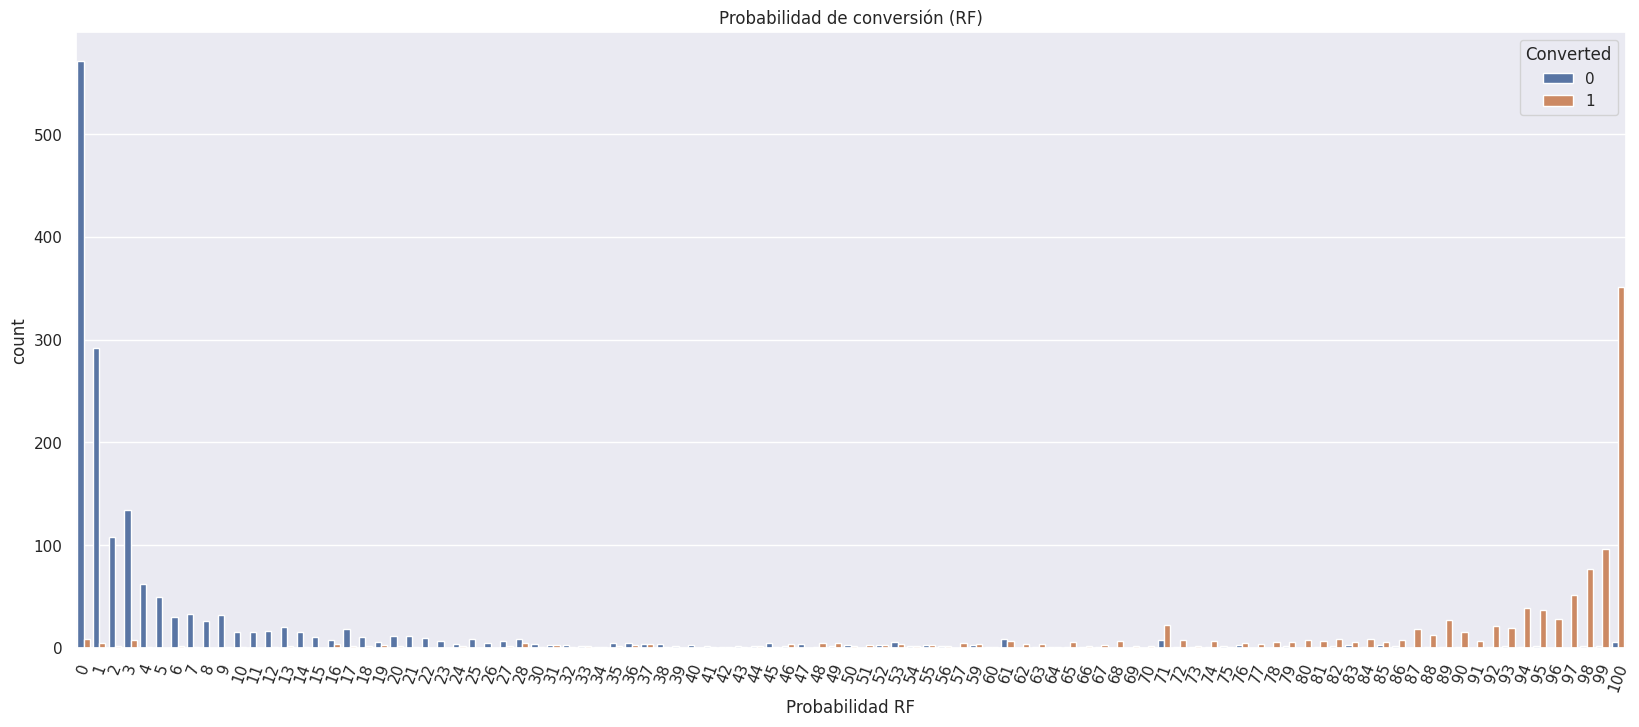

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.figure(figsize = (20, 8))
plt.title("Probabilidad de conversión (RF)")
sns.countplot(x = 'Probabilidad RF', data = preds, hue = 'Converted')
_=plt.xticks(rotation = 70)

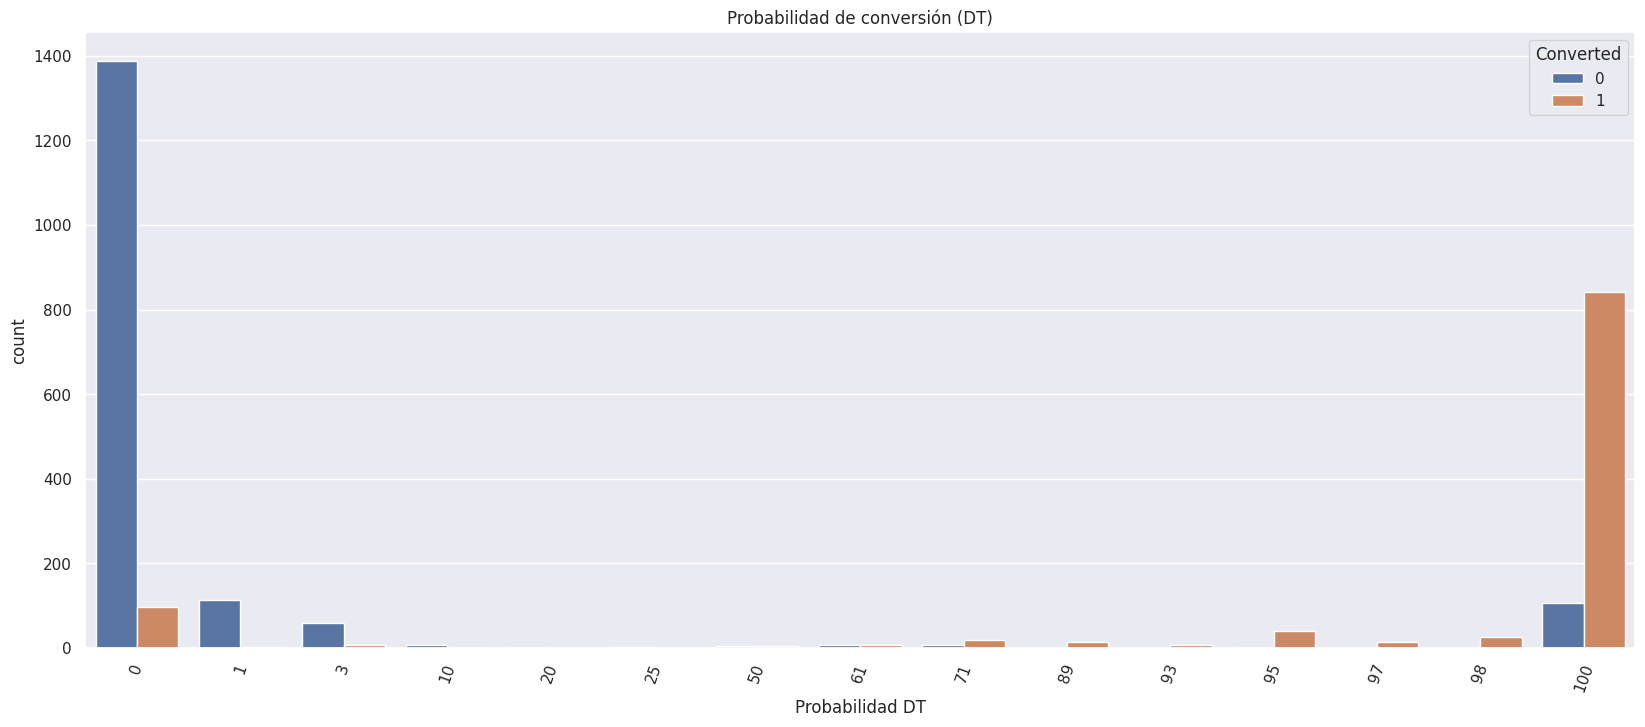

In [ ]:
sns.set_theme()
plt.figure(figsize = (20, 8))
plt.title("Probabilidad de conversión (DT)")
sns.countplot(x = 'Probabilidad DT', data = preds, hue = 'Converted')
_=plt.xticks(rotation = 70)

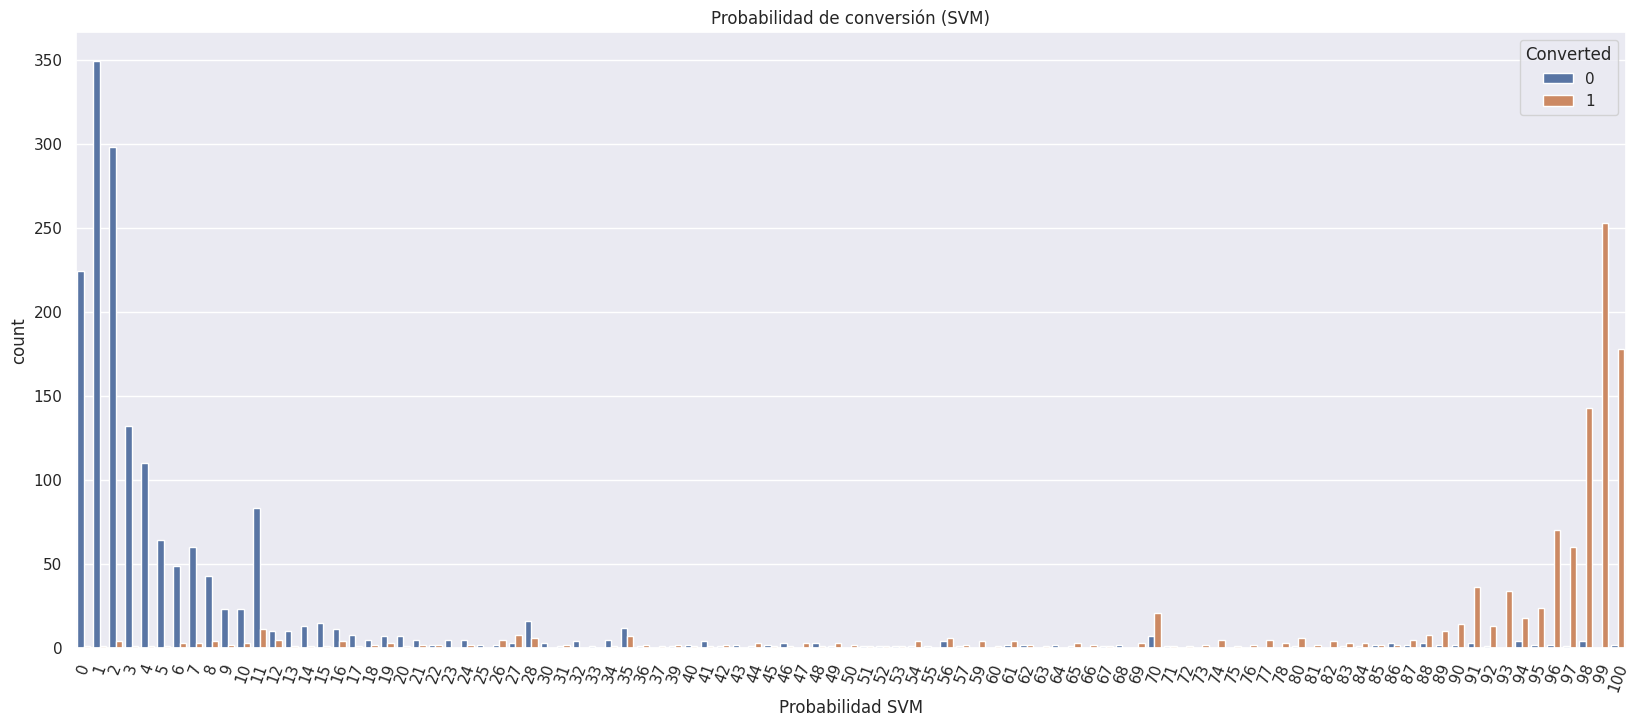

In [ ]:
sns.set_theme()
plt.figure(figsize = (20, 8))
plt.title("Probabilidad de conversión (SVM)")
sns.countplot(x = 'Probabilidad SVM', data = preds, hue = 'Converted')
_=plt.xticks(rotation = 70)

## Paso 4: Comparamos modelos

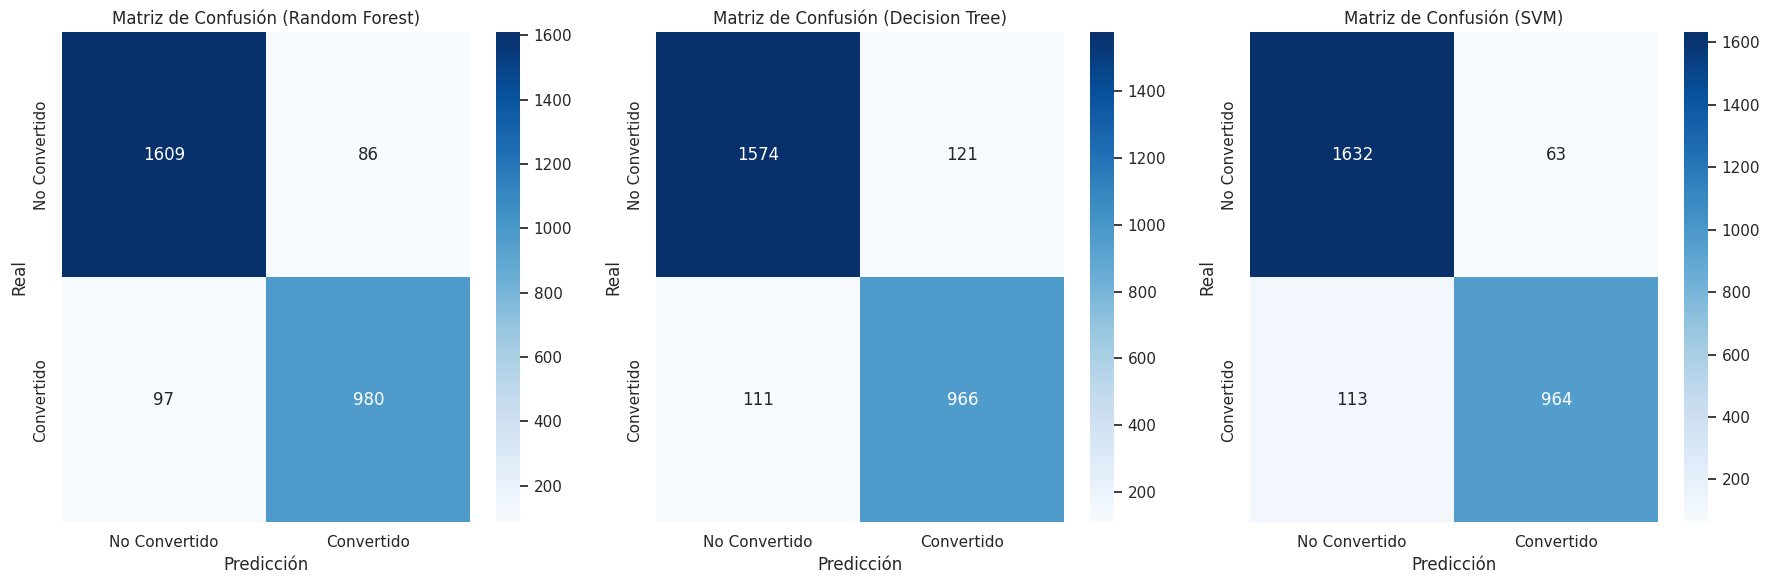

In [ ]:
# Matriz de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener las matrices de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_dt = confusion_matrix(y_test, y_pred_dt)  # Árbol de decisión
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Configurar la figura con tres subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Títulos de los gráficos
titles = ["Random Forest", "Decision Tree", "SVM"]

# Graficar las matrices de confusión
for i, (cm, title) in enumerate(zip([cm_rf, cm_dt, cm_svm], titles)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Convertido", "Convertido"], yticklabels=["No Convertido", "Convertido"], ax=axes[i])
    axes[i].set_title(f"Matriz de Confusión ({title})")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

# Ajustar el layout
plt.tight_layout()
plt.show()

In [ ]:
# Función para calcular métricas adicionales incluyendo accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_full_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Calcular métricas para cada modelo
full_metrics_rf = calculate_full_metrics(y_test, y_pred_rf)
full_metrics_dt = calculate_full_metrics(y_test, y_pred_dt)  # Árbol de decisión
full_metrics_svm = calculate_full_metrics(y_test, y_pred_svm)

# Crear un DataFrame con los resultados
full_metrics_df = pd.DataFrame({
    "Modelo": ["Random Forest", "Decision Tree", "SVM"],
    "Accuracy": [full_metrics_rf[0], full_metrics_dt[0], full_metrics_svm[0]],
    "Precisión": [full_metrics_rf[1], full_metrics_dt[1], full_metrics_svm[1]],
    "Recall": [full_metrics_rf[2], full_metrics_dt[2], full_metrics_svm[2]],
    "F1-Score": [full_metrics_rf[3], full_metrics_dt[3], full_metrics_svm[3]]
})

# Mostrar la tabla con las métricas
full_metrics_df

,Modelo,Accuracy,Precisión,Recall,F1-Score
0,Random Forest,0.933983,0.919325,0.909935,0.914606
1,Decision Tree,0.916306,0.888684,0.896936,0.892791
2,SVM,0.936508,0.938656,0.895079,0.916350


#### **1. Random Forest**
**Análisis:** Random Forest muestra un equilibrio sólido entre precisión y recall, lo que significa que es bastante bueno identificando los casos positivos sin generar demasiados falsos positivos o falsos negativos. Es un modelo robusto y resistente a sobreajuste gracias a su enfoque de ensamblado.

#### **2. Decision Tree**
**Análisis:** El Árbol de Decisión tiene el rendimiento más bajo en todas las métricas en comparación con los otros dos modelos. Su precisión y recall son inferiores, lo que indica que genera más errores en la clasificación. Tiende a sobreajustarse si no se podan correctamente las ramas.

#### **3. Support Vector Machine (SVM)**
**Análisis:** SVM tiene la mejor precisión de los tres modelos, lo que significa que cuando predice un lead como convertido, es más probable que realmente lo sea. Sin embargo, su recall es ligeramente menor que el de Random Forest, lo que significa que algunos casos positivos pueden estar siendo mal clasificados como negativos.

### **Conclusión: ¿Cuál es el mejor modelo?**
Si el objetivo principal es **minimizar falsos positivos** (casos en los que el modelo predice que un lead se convertirá, pero en realidad no lo hace), **SVM es la mejor opción** debido a su alta precisión.

Si el objetivo es **lograr un equilibrio entre precisión y recall**, **Random Forest es la mejor opción**, ya que mantiene un buen desempeño en ambas métricas sin comprometer ninguna en exceso.

Por otro lado, **Decision Tree no es la mejor opción**, ya que tiene el peor desempeño en todas las métricas.

Estudiamos overfitting y underfitting


In [ ]:
# Evaluar el rendimiento en el conjunto de entrenamiento para detectar overfitting o underfitting
train_pred_rf = rf_model.predict(X_train)
train_pred_dt = model.predict(X_train)  # Árbol de decisión
train_pred_svm = svm_model.predict(X_train)

# Calcular accuracy en entrenamiento
train_acc_rf = accuracy_score(y_train, train_pred_rf)
train_acc_dt = accuracy_score(y_train, train_pred_dt)
train_acc_svm = accuracy_score(y_train, train_pred_svm)

# Crear un DataFrame para comparar accuracy en entrenamiento y prueba
overfitting_df = pd.DataFrame({
    "Modelo": ["Random Forest", "Decision Tree", "SVM"],
    "Accuracy Entrenamiento": [train_acc_rf, train_acc_dt, train_acc_svm],
    "Accuracy Prueba": [full_metrics_rf[0], full_metrics_dt[0], full_metrics_svm[0]]
})

# Mostrar la tabla con las métricas de entrenamiento y prueba
overfitting_df


,Modelo,Accuracy Entrenamiento,Accuracy Prueba
0,Random Forest,0.990105,0.933983
1,Decision Tree,0.990105,0.916306
2,SVM,0.931664,0.936508


Tras la comparación de las métricas, vemos que el SVM resulta el vencedor. Los modelos de RF y DT están haciendo un overfitting considerable, presentando ~6% de diferencia entre los datos de train y test lo que sugiere que no están generalizando bien.

**GANADOR: SVM**

# Aprendizaje No Supervisado

## Paso 1: Reducción de dimensionalidad.

PCA (Análisis de Componentes Principales) es una técnica que reduce la cantidad de variables en un conjunto de datos mientras mantiene la mayor cantidad posible de información.

¿Cómo lo hace?

Transforma los datos en nuevas variables llamadas componentes principales, que son combinaciones de las originales. Las primeras componentes capturan la mayor parte de la variabilidad del dataset.

¿Para qué sirve?

Facilita la visualización de datos complejos.
Reduce el ruido y mejora el rendimiento de algunos modelos.
Ayuda a encontrar patrones ocultos en los datos.
Es como tomar una foto en 3D y verla en 2D manteniendo los detalles más importantes.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Remover la columna "Lead Number" ya que es solo un identificador
df_unsupervised = leads_df.drop(columns=["Lead Number"])

# Escalar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_unsupervised)

# Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Crear un DataFrame con los componentes principales
df_pca_df = pd.DataFrame(df_pca, columns=["PC1", "PC2"])

# Visualizar la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar la varianza explicada
explained_variance

array([0.06237007, 0.05363314])

El análisis de PCA (Análisis de Componentes Principales) muestra que los dos primeros componentes explican aproximadamente:

PC1: 6.19% de la varianza
PC2: 5.48% de la varianza
Esto indica que la variabilidad de los datos está distribuida en muchas dimensiones, y reducirlo a solo dos componentes no captura una gran proporción de la información. Aún así, podemos visualizar la segmentación en este espacio reducido.

Vamos a graficar los datos en función de estos dos componentes principales, diferenciando los casos de clientes que se matricularon (Converted = 1) y los que no (Converted = 0).

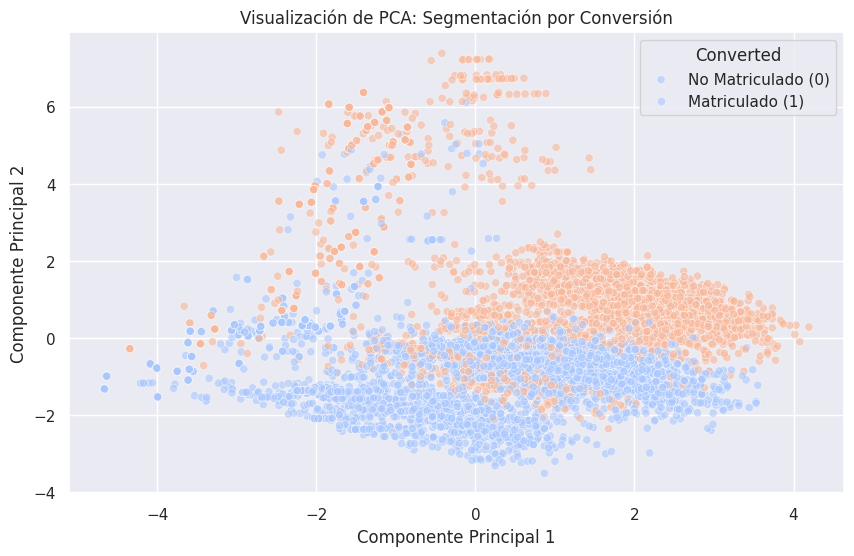

In [ ]:
# Agregar la variable objetivo al DataFrame de PCA para visualizar la segmentación
df_pca_df["Converted"] = df_unsupervised["Converted"]

# Crear la visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca_df, x="PC1", y="PC2", hue="Converted", alpha=0.6, palette="coolwarm")
plt.title("Visualización de PCA: Segmentación por Conversión")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Converted", labels=["No Matriculado (0)", "Matriculado (1)"])
plt.show()

## Paso 2: Estudiar segmentos de clientes

Estudiaremos los segmentos de clientes con tres técnicas de clustering diferentes:

- Clustering Jerárquico
- KMeans

Comenzaremos utilizando el clustering jerárquico para comprender qué número de clusters es el más óptimo.

Primero aplicamos sólo a variables numéricas, esto ya que el clustering jerárquico está basado en cálculo de distancias por lo que para mantenerlo simple usamos las variables numéricas.

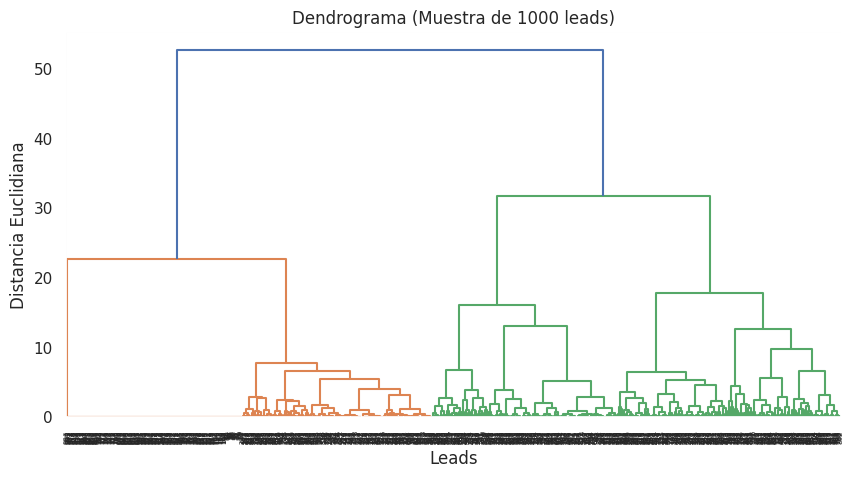

In [ ]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Seleccionar columnas numéricas relevantes para clustering
numerical_columns = [
    "TotalVisits", "Total Time Spent on Website", "Page Views Per Visit"
]

scaler = StandardScaler()

# Muestrear una parte de los datos para evitar problemas de memoria
sample_size = 1000  # Reducimos la cantidad de puntos analizados
df_sample = leads_df.sample(n=sample_size, random_state=42)

# Estandarizar los datos del subconjunto
df_sample_scaled = scaler.fit_transform(df_sample[numerical_columns])

# Crear el dendrograma para la estimación de clusters
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(df_sample_scaled, method='ward'))
plt.title("Dendrograma (Muestra de 1000 leads)")
plt.xlabel("Leads")
plt.ylabel("Distancia Euclidiana")
plt.show()

Podríamos usar algunas metodologías sofisticadas para estimar el número óptimo de clusters, pero con el dendrograma podemos ver a simple vista una buena división. En este caso, estimamos unos **5** clusters.

A continuación, aplicaremos nuevamente el método de clustering pero utilizando otro algoritmo, en este caso KMeans pero con todas las variables.

El clustering jerárquico es una forma muy visual de entender cómo se distribuyen los clusters en un dataset. En este caso usamos exlusivamente las variables numéricas

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Eliminar identificador y variable objetivo
X = leads_df.drop(columns=["Lead Number", "Converted"])

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means con 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
X["Cluster"] = kmeans.fit_predict(X_scaled)

# Obtener el tamaño de cada cluster
cluster_sizes = X["Cluster"].value_counts()

# Mostrar la distribución de los clusters
cluster_sizes.to_frame()

,count
Cluster,
1,4697
2,1883
4,1703
3,717
0,240


In [ ]:
cluster_means = X.groupby("Cluster").mean()

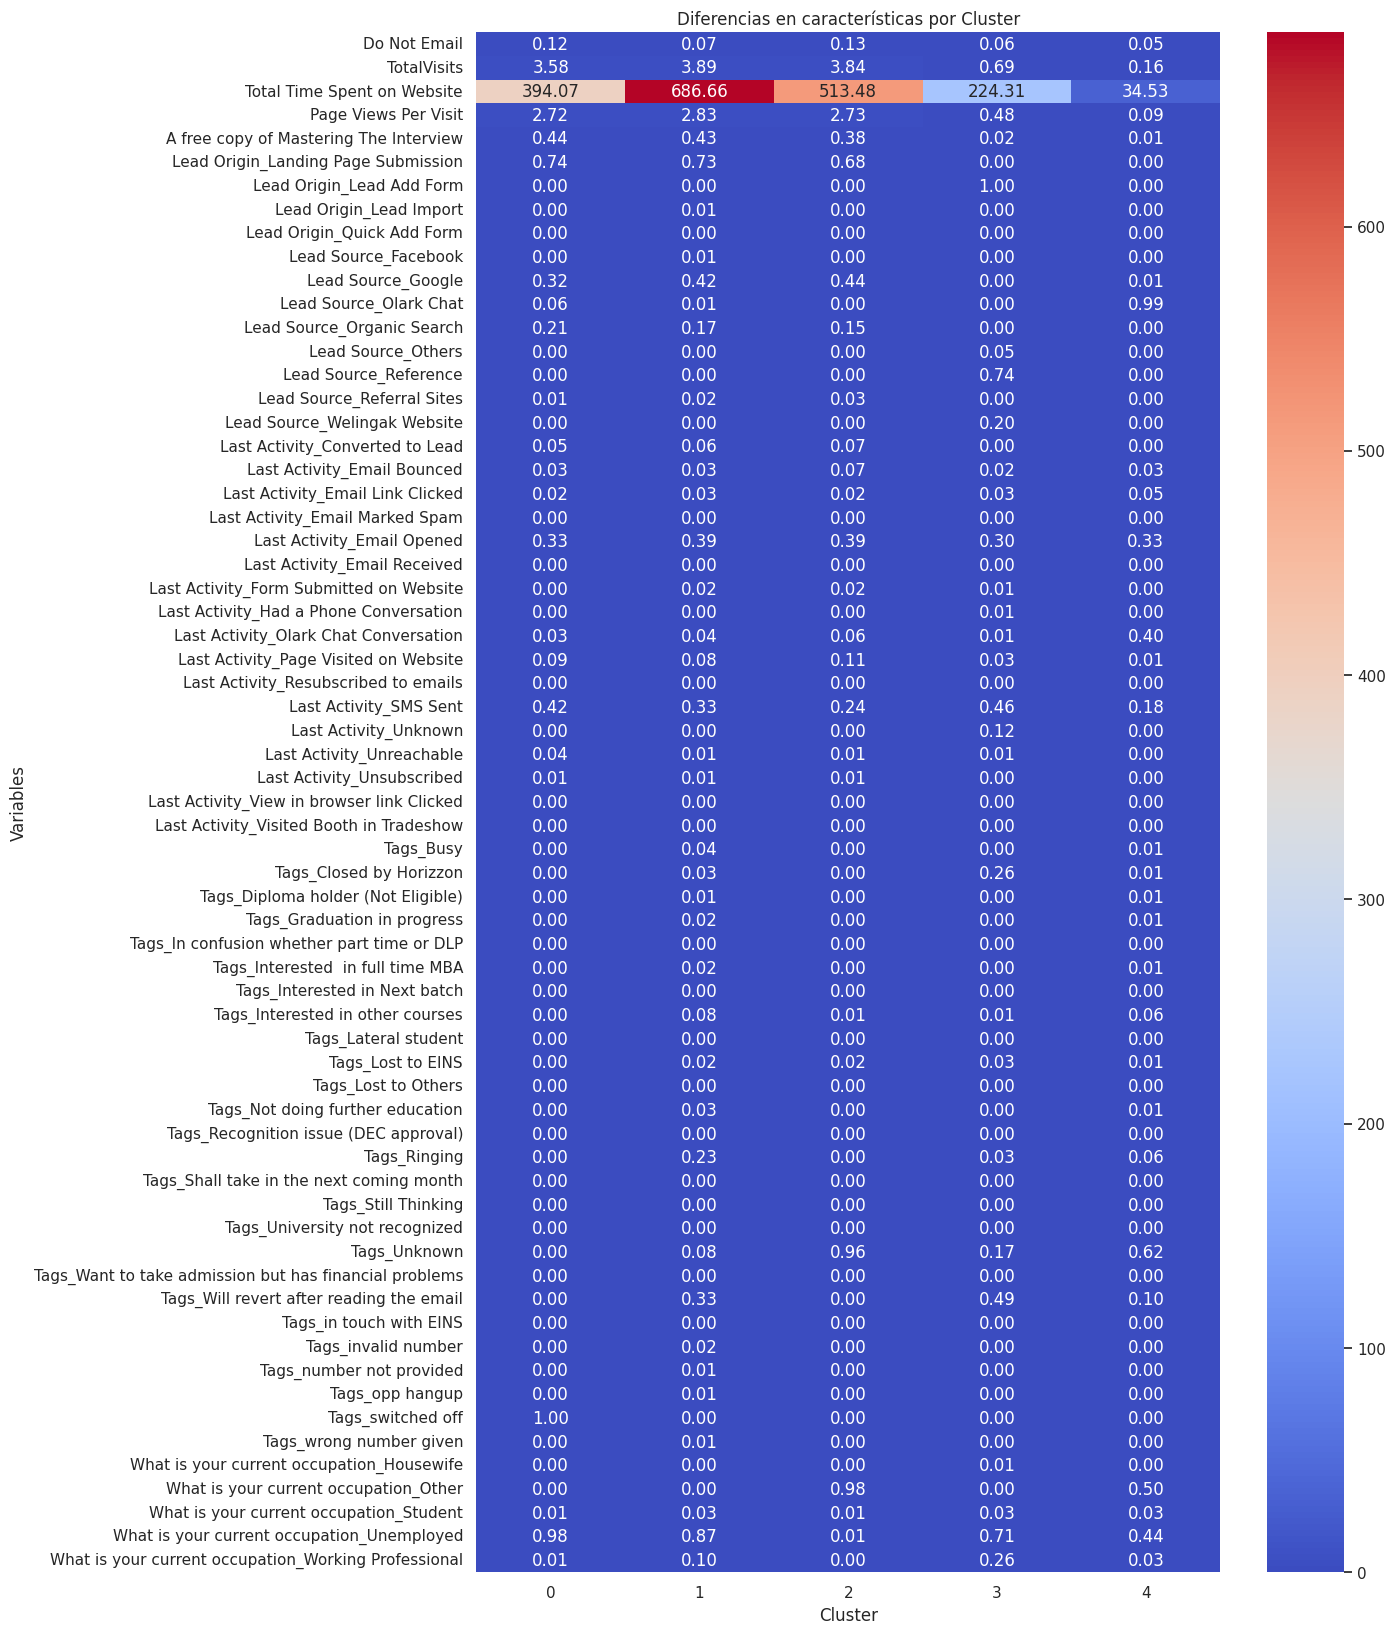

In [ ]:
plt.figure(figsize=(12, 20))
sns.heatmap(cluster_means.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Diferencias en características por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.show()

Cluster 0:

- Tiempo moderado en la web: 394.07 segundos.
- Número medio de visitas: 3.58.
- Interacción con correos electrónicos: 0.12 de usuarios marcados como "Do Not Email".
- Fuente de lead dominante: Landing Page Submission (0.74).
- Actividad reciente: Envío de SMS (0.42).
- Otras características: Uso moderado de Google como fuente (0.32).

Cluster 1:

- Tiempo alto en la web: 686.66 segundos.
- Número alto de visitas: 3.89.
- Mayor interacción con la web: Page Views Per Visit (2.83).
- Lead Source Google: 0.42.
- Lead Origin principal: Landing Page Submission (0.73).
- Actividad reciente: Conversión a lead en 0.06.

Cluster 2:

- Tiempo moderado en la web: 513.48 segundos.
- Número medio de visitas: 3.84.
- Página vistas por visita: 2.73.
- Lead Source dominante: Google (0.44).
- Lead Origin más común: Landing Page Submission (0.68).
- Conversión a lead baja: 0.07.

Cluster 3:

- Tiempo bajo en la web: 224.31 segundos.
- Bajas visitas: 0.69.
- Fuente de leads diferente: Lead Add Form (1.00).
- Actividad reciente: Casi nula en términos de email marketing y otras métricas.
- Fuente de leads por referencia: 0.74.

Cluster 4:

- Tiempo muy bajo en la web: 34.53 segundos.
- Visitas mínimas: 0.16.
- Fuente de leads distinta: Principalmente Olark Chat (0.99).
- Baja interacción con emails y marketing.
- Menor interés en educación avanzada.

Conclusión General

- Cluster 1 y 2 son los más comprometidos, con mayor tiempo en la web y más interacciones.
- Cluster 3 y 4 tienen muy baja actividad, con características únicas en la generación de leads.
- Cluster 0 está en un nivel intermedio, con engagement moderado.

El objetivo de este estudio era entender los segmentos de clientes a partir de técnicas de aprendizaje no supervisado.

Esto sumado a los modelos predictivos de Lead Scoring nos ayudan a dar un servicio especializado a nuestro cliente.